In [136]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import sys
sys.path.append('./../')
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_csv('./../data/raw/btcusdt.csv')
# from models.grid_bot import GridBot

In [262]:
class GridBot:
    def __init__(
            self,
            levels_num=10,
            balance=100000,
            levels_step=0.001, # must be > 0.0044
            fee=0.2181 / 100,
            use_up=False
    ):

        assert 0 < levels_step < 1, f'levels_step must be in (0, 1) range, {levels_step}'
        assert levels_num >= 1, f'levels_num must be greater than 0, {levels_num}'

        self.levels_num = levels_num
        self.levels_step = levels_step
        self.balance = balance
        self.history = []
        self.ref_price = None
        self.buy_orders = []
        self.sell_orders = []
        self.fee = fee
        self.buy_points = []
        self.sell_points = []
        self.use_up = use_up
        self.assets = 0
        self.wasted = []
        self.bought = [False for _ in range(self.levels_num)]

    def trade(self, df):
#         df = pd.read_csv(df_path)
        ref_price = df.iloc[0]['Open']

        self.ref_price = ref_price
        buy_amount = self.balance / self.levels_num
        buy_orders = [ref_price * (1 - k * self.levels_step) for k in range(1, self.levels_num + 1)]

        if self.use_up:
            sell_orders = [ref_price * (1 + k * self.levels_step) for k in range(self.levels_num)]
        
        elif self.use_up == False:
            sell_orders = [ref_price * (1 - k * self.levels_step) for k in range(self.levels_num)]
            
        else:
            sell_orders = []
            for k in range(self.levels_num):
                if k > int(self.levels_num*0.2):
                    k = k - int(self.levels_num*0.2)
                    sell_orders += [ref_price * (1 - k * self.levels_step)]
                else:
                    sell_orders += [ref_price * (1 + k * self.levels_step)]
            


        self.buy_orders = buy_orders
        self.sell_orders = sell_orders

        for index, row in tqdm(df.iterrows()):

            sell_amount = self.assets / sum(self.bought) if sum(self.bought) else 0

            for i in range(len(self.bought)):
                if self.bought[i] and row.High >= sell_orders[i]:
                    self.bought[i] = False
                    
                    self.balance += (
                        sell_amount * sell_orders[i] * (1 - self.fee)
                    )
                    self.wasted += [sell_amount * sell_orders[i] * self.fee]
                    self.assets -= sell_amount

                    self.history += [self.balance]
                    self.sell_points += [(index, sell_orders[i])]

                elif not self.bought[i] and row.Low <= buy_orders[i] and self.balance >= buy_amount:
                    self.bought[i] = True
                    self.balance -= buy_amount
                    self.assets += (1 - self.fee) * buy_amount / buy_orders[i]
                    self.wasted += [self.fee * buy_amount / buy_orders[i]]
                    self.history += [self.balance]
                    self.buy_points += [(index, buy_orders[i])]
                    
        
        if self.assets != 0:
            self.balance += (
                        self.assets * row.Close * (1 - self.fee)
                    )
            self.wasted += [self.assets * row.Close * self.fee]
            self.assets -= self.assets

            self.history += [self.balance]
            self.sell_points += [(index, row.Close)]
                

        return self
    
    def plot(self, df):
#         df = pd.read_csv(df_path)
        self = self.trade(df)
        plt.figure(figsize=(24,8))
        plt.plot(df.index, (df.High+df.Low)/2, color='black', marker='o', linestyle='-',
             linewidth=1, markersize=1)

        plt.plot(df.index, [self.ref_price for i in df.index], color='blue', linewidth=3, label='ref')
        plt.plot(df.index, [self.buy_orders for i in df.index], color='green', linewidth=0.5, linestyle='--' )
        plt.plot(df.index, [self.sell_orders for i in df.index] , color='red', linewidth=0.5, linestyle='--')

        plt.plot([i[0] for i in self.sell_points], [i[1] for i in self.sell_points] , 'ro', linewidth=2)
        plt.plot([i[0] for i in self.buy_points], [i[1] for i in self.buy_points] , 'go', linewidth=2)

        plt.legend()
        plt.show()

In [70]:
grid_bot = GridBot(levels_num=12, balance=100000, use_up = False, levels_step=0.002)
grid_bot.trade('./../data/raw/btcusdt.csv')
print(grid_bot.balance)

4321it [00:00, 15108.59it/s]

100569.3783247354


In [71]:
sum(grid_bot.wasted)

438.41337828189046

In [72]:
len(grid_bot.buy_points), len(grid_bot.sell_points)

(24, 24)

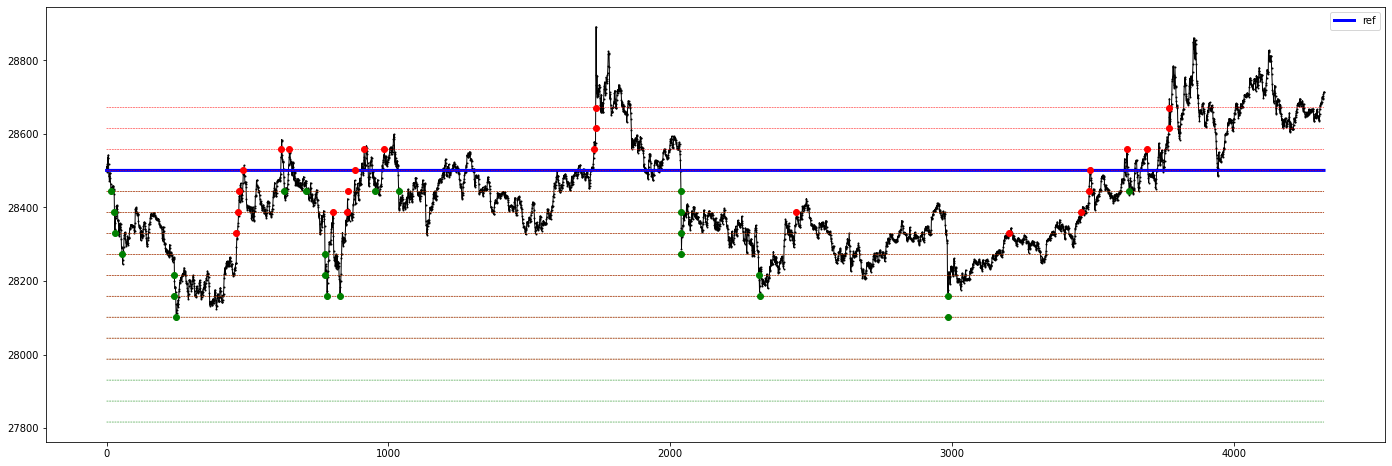

In [73]:
plt.figure(figsize=(24,8))
plt.plot(df.index, (df.High+df.Low)/2, color='black', marker='o', linestyle='-',
     linewidth=1, markersize=1)

plt.plot(df.index, [grid_bot.ref_price for i in df.index ], color='blue', linewidth=3, label='ref')
plt.plot(df.index, [grid_bot.buy_orders for i in df.index ], color ='green', linewidth =0.5, linestyle='--' )
plt.plot(df.index, [grid_bot.sell_orders for i in df.index ] , color ='red', linewidth =0.5, linestyle='--')

plt.plot([i[0] for i in grid_bot.sell_points], [i[1] for i in grid_bot.sell_points] , 'ro', linewidth =2)
plt.plot([i[0] for i in grid_bot.buy_points], [i[1] for i in grid_bot.buy_points] , 'go', linewidth =2)

plt.legend()
plt.show()

In [75]:
day_1 = df[(df['Time'] > '2023-10-16') & (df['Time'] < '2023-10-18')]
day_2 = df[(df['Time'] > '2023-10-17') & (df['Time'] < '2023-10-19')]
day_3 = df[(df['Time'] > '2023-10-18') & (df['Time'] < '2023-10-20')]

In [ ]:
df

In [84]:
shrp = []
np.random.seed(42)
for k in range(20):
    l_n, l_s = np.random.randint(10, 14), np.random.randint(1, 10)/1000 #0.0012
    for d in [df]:#[day_1, day_2, day_3]:
        grid_bot = GridBot(levels_num=l_n, balance=100000, use_up = False, levels_step=l_s)
        grid_bot.trade(d)
        shrp.append(grid_bot.balance - 1e5)

4321it [00:00, 14971.82it/s]
4321it [00:00, 16747.57it/s]
4321it [00:00, 16878.62it/s]
4321it [00:00, 14977.75it/s]
4321it [00:00, 15032.57it/s]
4321it [00:00, 16555.64it/s]
4321it [00:00, 14537.19it/s]
4321it [00:00, 15108.06it/s]
4321it [00:00, 16682.96it/s]
4321it [00:00, 14451.18it/s]
4321it [00:00, 15944.25it/s]
4321it [00:00, 16748.15it/s]
4321it [00:00, 16747.59it/s]
4321it [00:00, 16618.47it/s]
4321it [00:00, 13804.78it/s]
4321it [00:00, 14499.65it/s]
4321it [00:00, 15108.09it/s]
4321it [00:00, 15148.95it/s]
4321it [00:00, 16747.65it/s]
4321it [00:00, 15108.10it/s]


In [85]:
shrp

[585.6238660704112,
 234.03021804612945,
 687.1540995547548,
 669.5806096357992,
 195.02518170513213,
 702.7486392844148,
 180.02324465088896,
 457.87918121763505,
 683.2539896824164,
 422.65770573934424,
 624.6855450497678,
 549.4550174611504,
 274.5417067981616,
 803.496731562831,
 516.4875346670742,
 211.1859283062804,
 572.628416295629,
 559.5281625560019,
 274.5417067981616,
 569.3783247354004]

In [86]:
np.mean(shrp)/ np.std(shrp)

2.564592713733428

In [82]:
shrp = []
np.random.seed(42)
for k in range(20):
    l_n, l_s = np.random.randint(10, 14), np.random.randint(1, 10)/1000 #0.0012
    for d in [df]: #[day_1, day_2, day_3]:
        grid_bot = GridBot(levels_num=l_n, balance=100000, use_up = True, levels_step=l_s)
        grid_bot.trade(d)
        shrp.append(grid_bot.balance - 1e5)

4321it [00:00, 15055.39it/s]
4321it [00:00, 16683.52it/s]
4321it [00:00, 16813.40it/s]
4321it [00:00, 14746.97it/s]
4321it [00:00, 15214.50it/s]
4321it [00:00, 16429.73it/s]
4321it [00:00, 14548.53it/s]
4321it [00:00, 14425.78it/s]
4321it [00:00, 16619.35it/s]
4321it [00:00, 13849.42it/s]
4321it [00:00, 15944.81it/s]
4321it [00:00, 16429.79it/s]
4321it [00:00, 16813.36it/s]
4321it [00:00, 16813.33it/s]
4321it [00:00, 14392.74it/s]
4321it [00:00, 13760.83it/s]
4321it [00:00, 15108.33it/s]
4321it [00:00, 15055.36it/s]
4321it [00:00, 16812.75it/s]
4321it [00:00, 15055.44it/s]


In [83]:
np.mean(shrp)/ np.std(shrp)

1.4220228624630171

In [199]:
import ccxt
import pandas as pd
from datetime import datetime, timedelta
import time

# Initialize Binance exchange
exchange = ccxt.binance()

# Define symbol and timeframe
symbol = 'BTC/USDT'
timeframe = '1m'

# Calculate the start and end time for the one-week period
end_time = exchange.milliseconds()  # current time in milliseconds
start_time = end_time - 21 * 24 * 60 * 60 * 1000  # 21 days in milliseconds

# Initialize an empty DataFrame to store the data
all_data = pd.DataFrame()

# Define the limit for each request
limit = 1000

# Fetch OHLCV data in chunks until all data is retrieved
while True:
    # Fetch OHLCV data
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since=start_time, limit=limit)

    # Break the loop if no more data is available
    if not ohlcv:
        break

    # Convert the data to a DataFrame
    df = pd.DataFrame(ohlcv, columns=['timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])

    # Convert timestamps to human-readable format
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

    # Append the current chunk of data to the overall DataFrame
    all_data = pd.concat([all_data, df]) #.append(df, ignore_index=True)

    # Update the start_time for the next request
    start_time = ohlcv[-1][0] + 1  # set the start_time to the timestamp of the last retrieved candle + 1
    
    print(all_data.shape)
    # Pause for 3 seconds before making the next request
    time.sleep(3)

# Print the complete DataFrame
print(all_data)

(1000, 6)
(2000, 6)
(3000, 6)
(4000, 6)
(5000, 6)
(6000, 6)
(7000, 6)
(8000, 6)
(9000, 6)
(10000, 6)
(11000, 6)
(12000, 6)
(13000, 6)
(14000, 6)
(15000, 6)
(16000, 6)
(17000, 6)
(18000, 6)
(19000, 6)
(20000, 6)
(21000, 6)
(22000, 6)
(23000, 6)
(24000, 6)
(25000, 6)
(26000, 6)
(27000, 6)
(28000, 6)
(29000, 6)
(30000, 6)
(30241, 6)
              timestamp      open      high       low     close      volume
0   2023-10-01 22:17:00  27392.04  28000.00  27392.03  27994.54  1165.76179
1   2023-10-01 22:18:00  27994.54  28000.00  27750.00  27872.69   731.89361
2   2023-10-01 22:19:00  27874.98  27914.89  27831.00  27861.39   344.48555
3   2023-10-01 22:20:00  27861.40  27876.80  27735.30  27750.57   225.79096
4   2023-10-01 22:21:00  27750.57  27825.00  27750.56  27799.18   150.65462
..                  ...       ...       ...       ...       ...         ...
236 2023-10-22 22:13:00  29798.96  29798.97  29798.96  29798.96     1.44329
237 2023-10-22 22:14:00  29798.96  29808.08  29798.96  29808

In [219]:
all_data.to_csv('./btcusdt_01_22.csv')

In [99]:
all_data = pd.read_csv('./btcusdt_01_22.csv')

In [104]:
all_data.drop(columns=['Unnamed: 0'], inplace=True)

In [120]:
all_data
k = 1
all_data[(all_data['timestamp'] > f'2023-10-0{k}') & (all_data['timestamp'] < f'2023-10-0{k+1}')]

,timestamp,Open,High,Low,Close,Volume
0,2023-10-01 22:17:00,27392.04,28000.00,27392.03,27994.54,1165.76179
1,2023-10-01 22:18:00,27994.54,28000.00,27750.00,27872.69,731.89361
2,2023-10-01 22:19:00,27874.98,27914.89,27831.00,27861.39,344.48555
3,2023-10-01 22:20:00,27861.40,27876.80,27735.30,27750.57,225.79096
4,2023-10-01 22:21:00,27750.57,27825.00,27750.56,27799.18,150.65462
...,...,...,...,...,...,...
98,2023-10-01 23:55:00,27978.10,27981.10,27967.44,27967.44,20.85064
99,2023-10-01 23:56:00,27967.45,27968.90,27966.33,27966.34,4.32485
100,2023-10-01 23:57:00,27966.34,27991.06,27966.33,27983.63,26.76229
101,2023-10-01 23:58:00,27983.63,27986.38,27979.54,27986.37,20.21856


## 1 day sharp

In [397]:
shrp = {}
np.random.seed(42)
array_1, array_2 = [i for i in range(3, 14)], [i /10000 for i in range(10, 21)]
comb_array = np.array(np.meshgrid(array_1, array_2)).T.reshape(-1, 2)

for l_n, l_s in comb_array:
    l_n = int(l_n)
    shrp[f'l_n:{l_n}, l_s:{l_s}'] = []
    for k in range(10, 22):
        df = all_data[(all_data['timestamp'] > f'2023-10-{k}') & (all_data['timestamp'] < f'2023-10-{k+1}')]
        grid_bot = GridBot(levels_num=l_n, balance=100000, use_up = False, levels_step=l_s)
        grid_bot.trade(df)
        shrp[f'l_n:{l_n}, l_s:{l_s}'].append(grid_bot.balance - 1e5)

1440it [00:00, 25262.66it/s]
1440it [00:00, 26395.29it/s]
1440it [00:00, 26186.67it/s]
1440it [00:00, 26668.13it/s]
1440it [00:00, 27155.04it/s]
1440it [00:00, 26660.59it/s]
1440it [00:00, 27152.60it/s]
1440it [00:00, 26178.50it/s]
1440it [00:00, 26656.59it/s]
1440it [00:00, 26659.30it/s]
1440it [00:00, 27165.79it/s]
1440it [00:00, 26112.51it/s]
1440it [00:00, 25263.62it/s]
1440it [00:00, 26186.67it/s]
1440it [00:00, 25263.19it/s]
1440it [00:00, 25714.95it/s]
1440it [00:00, 25710.24it/s]
1440it [00:00, 24824.49it/s]
1440it [00:00, 24824.39it/s]
1440it [00:00, 25267.10it/s]
1440it [00:00, 25713.30it/s]
1440it [00:00, 26178.50it/s]
1440it [00:00, 26177.93it/s]
1440it [00:00, 26186.78it/s]
1440it [00:00, 25713.74it/s]
1440it [00:00, 25720.53it/s]
1440it [00:00, 25713.19it/s]
1440it [00:00, 25260.87it/s]
1440it [00:00, 26182.81it/s]
1440it [00:00, 21175.70it/s]
1440it [00:00, 24832.04it/s]
1440it [00:00, 24824.59it/s]
1440it [00:00, 25259.39it/s]
1440it [00:00, 27168.11it/s]
1440it [00:00,

1440it [00:00, 23223.83it/s]
1440it [00:00, 22854.82it/s]
1440it [00:00, 22496.60it/s]
1440it [00:00, 23604.30it/s]
1440it [00:00, 22497.19it/s]
1440it [00:00, 21491.04it/s]
1440it [00:00, 21815.03it/s]
1440it [00:00, 22154.96it/s]
1440it [00:00, 22498.19it/s]
1440it [00:00, 22499.37it/s]
1440it [00:00, 23223.83it/s]
1440it [00:00, 22858.11it/s]
1440it [00:00, 22151.63it/s]
1440it [00:00, 22486.13it/s]
1440it [00:00, 22855.17it/s]
1440it [00:00, 23223.92it/s]
1440it [00:00, 22854.82it/s]
1440it [00:00, 22861.40it/s]
1440it [00:00, 23223.74it/s]
1440it [00:00, 22853.87it/s]
1440it [00:00, 22497.94it/s]
1440it [00:00, 22859.15it/s]
1440it [00:00, 23222.94it/s]
1440it [00:00, 23223.74it/s]
1440it [00:00, 22500.21it/s]
1440it [00:00, 21178.23it/s]
1440it [00:00, 21494.02it/s]
1440it [00:00, 22154.31it/s]
1440it [00:00, 22497.94it/s]
1440it [00:00, 22857.59it/s]
1440it [00:00, 22500.21it/s]
1440it [00:00, 22854.65it/s]
1440it [00:00, 22500.54it/s]
1440it [00:00, 22884.52it/s]
1440it [00:00,

1440it [00:00, 19199.56it/s]
1440it [00:00, 18462.09it/s]
1440it [00:00, 18462.20it/s]
1440it [00:00, 18699.70it/s]
1440it [00:00, 18699.53it/s]
1440it [00:00, 17997.50it/s]
1440it [00:00, 18459.83it/s]
1440it [00:00, 18947.14it/s]
1440it [00:00, 20000.13it/s]
1440it [00:00, 18699.01it/s]
1440it [00:00, 18698.37it/s]
1440it [00:00, 18949.40it/s]
1440it [00:00, 19199.56it/s]
1440it [00:00, 19723.98it/s]
1440it [00:00, 19457.42it/s]
1440it [00:00, 19456.92it/s]
1440it [00:00, 19725.59it/s]
1440it [00:00, 19459.24it/s]
1440it [00:00, 18461.01it/s]
1440it [00:00, 18701.26it/s]
1440it [00:00, 19724.56it/s]
1440it [00:00, 20001.32it/s]
1440it [00:00, 19723.40it/s]
1440it [00:00, 19725.72it/s]
1440it [00:00, 19198.03it/s]
1440it [00:00, 18699.64it/s]
1440it [00:00, 18699.70it/s]
1440it [00:00, 19460.24it/s]
1440it [00:00, 19200.66it/s]
1440it [00:00, 18945.41it/s]
1440it [00:00, 19726.10it/s]
1440it [00:00, 19462.12it/s]
1440it [00:00, 19457.42it/s]
1440it [00:00, 19456.79it/s]
1440it [00:00,

1440it [00:00, 17561.02it/s]
1440it [00:00, 17143.81it/s]
1440it [00:00, 16747.54it/s]
1440it [00:00, 17347.81it/s]
1440it [00:00, 17349.76it/s]
1440it [00:00, 17777.08it/s]
1440it [00:00, 17351.05it/s]
1440it [00:00, 17349.86it/s]
1440it [00:00, 17140.35it/s]
1440it [00:00, 17776.19it/s]
1440it [00:00, 17348.21it/s]
1440it [00:00, 17560.72it/s]
1440it [00:00, 17561.07it/s]
1440it [00:00, 16742.80it/s]
1440it [00:00, 17345.32it/s]
1440it [00:00, 17559.80it/s]
1440it [00:00, 17776.35it/s]
1440it [00:00, 17143.47it/s]
1440it [00:00, 15822.59it/s]
1440it [00:00, 16744.70it/s]
1440it [00:00, 16549.98it/s]
1440it [00:00, 16365.58it/s]
1440it [00:00, 17349.06it/s]
1440it [00:00, 17532.88it/s]
1440it [00:00, 17559.75it/s]
1440it [00:00, 17558.67it/s]
1440it [00:00, 16939.70it/s]
1440it [00:00, 16744.75it/s]
1440it [00:00, 17141.23it/s]
1440it [00:00, 17561.89it/s]
1440it [00:00, 17336.56it/s]
1440it [00:00, 17336.66it/s]
1440it [00:00, 17566.33it/s]
1440it [00:00, 17349.11it/s]
1440it [00:00,

1440it [00:00, 15483.72it/s]
1440it [00:00, 15483.88it/s]
1440it [00:00, 15658.54it/s]
1440it [00:00, 15998.66it/s]
1440it [00:00, 15998.91it/s]
1440it [00:00, 15824.20it/s]
1440it [00:00, 15651.00it/s]
1440it [00:00, 15482.69it/s]
1440it [00:00, 15318.04it/s]
1440it [00:00, 15822.96it/s]
1440it [00:00, 15998.83it/s]
1440it [00:00, 14998.89it/s]
1440it [00:00, 14256.64it/s]
1440it [00:00, 14401.90it/s]
1440it [00:00, 14843.23it/s]
1440it [00:00, 15158.12it/s]
1440it [00:00, 14997.85it/s]
1440it [00:00, 14257.38it/s]
1440it [00:00, 14844.39it/s]
1440it [00:00, 14545.74it/s]
1440it [00:00, 15650.79it/s]
1440it [00:00, 15000.30it/s]
1440it [00:00, 14257.45it/s]
1440it [00:00, 15484.32it/s]
1440it [00:00, 15650.87it/s]
1440it [00:00, 14694.01it/s]
1440it [00:00, 15158.00it/s]
1440it [00:00, 15484.16it/s]
1440it [00:00, 15822.96it/s]
1440it [00:00, 15822.92it/s]
1440it [00:00, 15821.72it/s]
1440it [00:00, 15483.72it/s]
1440it [00:00, 15824.62it/s]
1440it [00:00, 15823.62it/s]
1440it [00:00,

1440it [00:00, 14257.05it/s]
1440it [00:00, 13978.65it/s]
1440it [00:00, 14256.88it/s]
1440it [00:00, 14400.22it/s]
1440it [00:00, 14399.43it/s]
1440it [00:00, 14258.22it/s]
1440it [00:00, 14228.03it/s]
1440it [00:00, 14399.05it/s]
1440it [00:00, 14257.01it/s]
1440it [00:00, 14257.01it/s]
1440it [00:00, 14257.89it/s]
1440it [00:00, 14544.41it/s]
1440it [00:00, 14544.90it/s]
1440it [00:00, 14399.19it/s]
1440it [00:00, 14257.15it/s]
1440it [00:00, 14692.80it/s]
1440it [00:00, 14545.28it/s]
1440it [00:00, 14115.07it/s]
1440it [00:00, 14544.44it/s]
1440it [00:00, 14117.58it/s]
1440it [00:00, 14400.70it/s]
1440it [00:00, 14544.79it/s]
1440it [00:00, 14544.44it/s]
1440it [00:00, 14544.83it/s]
1440it [00:00, 14386.88it/s]
1440it [00:00, 14116.26it/s]
1440it [00:00, 14399.22it/s]
1440it [00:00, 14545.46it/s]
1440it [00:00, 14544.34it/s]
1440it [00:00, 14544.37it/s]
1440it [00:00, 14258.93it/s]
1440it [00:00, 14400.32it/s]
1440it [00:00, 14398.92it/s]
1440it [00:00, 14258.66it/s]
1440it [00:00,

In [398]:
list_of_sharp_bottom = []
for k in list(shrp.keys()):
    sharp_one = np.mean(shrp[k]) / np.std(shrp[k])
    print(sharp_one)
    list_of_sharp_bottom.append(sharp_one)

-1.0925319263469389
-1.0725233699918852
-1.0265123190431857
-1.1030922681292286
-1.0290350143352915
-1.0109900212978693
-1.021328134632705
-1.0135156223512336
-1.0236990569114268
-1.038153859732992
-1.0243088027515326
-0.9965979366672209
-1.0398377619282573
-1.0125637406091115
-1.0703045871879822
-1.03306493259151
-1.0335248787134548
-1.0082903783093893
-1.0200954544866565
-1.0255475252429207
-1.0275789711877108
-0.9931564900823953
-1.009282177785033
-1.0251098389892657
-1.010908265346462
-1.0536896150444839
-1.0310958363567186
-1.0215183334931255
-0.9890433552515351
-0.9799000890768781
-0.9867451685710703
-0.9865563085010183
-0.9709606994911982
-1.0123499760226857
-1.0303092407821102
-1.0087835974362689
-1.042427917999819
-1.006979310167622
-0.9986626569920768
-0.974853201379865
-0.9616034800581611
-0.9651906030562759
-0.9484978897885752
-0.9316609596050988
-1.00798106673676
-1.0259793609504488
-0.9985500067339818
-1.027604882496627
-0.9903780197472559
-0.9802392857715161
-0.943833741

In [399]:
np.mean(list_of_sharp_bottom), np.std(list_of_sharp_bottom)

(-0.9492175882510739, 0.07312078266680268)

In [401]:
list_of_sharp_bottom_good_days = []
for k in list(shrp.keys()):
    pos_ar = [i for i in shrp[k] if i > 0 ]
    list_of_sharp_bottom_good_days.append(np.mean(pos_ar) / np.std(pos_ar))

In [402]:
filtered_array_down = [x for x in list_of_sharp_bottom_good_days if isinstance(x, (float, np.floating)) and not np.isnan(x) and not np.isinf(x)]

In [403]:
np.mean(filtered_array_down), np.std(filtered_array_down)

(nan, nan)

## Up

In [404]:
shrp = {}
np.random.seed(42)
array_1, array_2 = [i for i in range(3, 14)], [i /10000 for i in range(10, 21)]
comb_array = np.array(np.meshgrid(array_1, array_2)).T.reshape(-1, 2)

for l_n, l_s in comb_array:
    l_n = int(l_n)
    shrp[f'l_n:{l_n}, l_s:{l_s}'] = []
    for k in range(10, 22):
        df = all_data[(all_data['timestamp'] > f'2023-10-{k}') & (all_data['timestamp'] < f'2023-10-{k+1}')]
        grid_bot = GridBot(levels_num=l_n, balance=100000, use_up = True, levels_step=l_s)
        grid_bot.trade(df)
        shrp[f'l_n:{l_n}, l_s:{l_s}'].append(grid_bot.balance - 1e5)

1440it [00:00, 25800.63it/s]
1440it [00:00, 26184.17it/s]
1440it [00:00, 26181.67it/s]
1440it [00:00, 26178.27it/s]
1440it [00:00, 25715.38it/s]
1440it [00:00, 26674.25it/s]
1440it [00:00, 26182.69it/s]
1440it [00:00, 26421.04it/s]
1440it [00:00, 25684.87it/s]
1440it [00:00, 26663.42it/s]
1440it [00:00, 27165.79it/s]
1440it [00:00, 26662.60it/s]
1440it [00:00, 26180.42it/s]
1440it [00:00, 25262.45it/s]
1440it [00:00, 24399.08it/s]
1440it [00:00, 25262.66it/s]
1440it [00:00, 26664.60it/s]
1440it [00:00, 27167.50it/s]
1440it [00:00, 27170.31it/s]
1440it [00:00, 26146.76it/s]
1440it [00:00, 25263.30it/s]
1440it [00:00, 25711.00it/s]
1440it [00:00, 24829.49it/s]
1440it [00:00, 25715.38it/s]
1440it [00:00, 25700.17it/s]
1440it [00:00, 25707.17it/s]
1440it [00:00, 26177.13it/s]
1440it [00:00, 26661.89it/s]
1440it [00:00, 26661.77it/s]
1440it [00:00, 26178.27it/s]
1440it [00:00, 26177.02it/s]
1440it [00:00, 25710.79it/s]
1440it [00:00, 26176.23it/s]
1440it [00:00, 26183.15it/s]
1440it [00:00,

1440it [00:00, 22498.11it/s]
1440it [00:00, 21492.57it/s]
1440it [00:00, 21814.72it/s]
1440it [00:00, 22151.47it/s]
1440it [00:00, 22500.62it/s]
1440it [00:00, 22500.96it/s]
1440it [00:00, 22151.55it/s]
1440it [00:00, 22154.56it/s]
1440it [00:00, 22501.13it/s]
1440it [00:00, 22854.56it/s]
1440it [00:00, 22497.52it/s]
1440it [00:00, 22857.68it/s]
1440it [00:00, 22858.02it/s]
1440it [00:00, 22477.93it/s]
1440it [00:00, 22154.40it/s]
1440it [00:00, 22856.81it/s]
1440it [00:00, 22863.04it/s]
1440it [00:00, 22855.69it/s]
1440it [00:00, 21815.82it/s]
1440it [00:00, 22154.64it/s]
1440it [00:00, 22868.15it/s]
1440it [00:00, 22834.60it/s]
1440it [00:00, 22854.99it/s]
1440it [00:00, 22497.52it/s]
1440it [00:00, 22496.60it/s]
1440it [00:00, 22497.02it/s]
1440it [00:00, 22852.83it/s]
1440it [00:00, 22151.63it/s]
1440it [00:00, 22050.86it/s]
1440it [00:00, 22498.28it/s]
1440it [00:00, 22500.88it/s]
1440it [00:00, 22500.12it/s]
1440it [00:00, 22151.39it/s]
1440it [00:00, 23223.20it/s]
1440it [00:00,

1440it [00:00, 19725.91it/s]
1440it [00:00, 20000.32it/s]
1440it [00:00, 19726.43it/s]
1440it [00:00, 16735.89it/s]
1440it [00:00, 19726.04it/s]
1440it [00:00, 20261.66it/s]
1440it [00:00, 19200.35it/s]
1440it [00:00, 18701.90it/s]
1440it [00:00, 19443.02it/s]
1440it [00:00, 13980.69it/s]
1440it [00:00, 18944.22it/s]
1440it [00:00, 19724.30it/s]
1440it [00:00, 19457.48it/s]
1440it [00:00, 18947.61it/s]
1440it [00:00, 19726.49it/s]
1440it [00:00, 19458.24it/s]
1440it [00:00, 19185.90it/s]
1440it [00:00, 20000.72it/s]
1440it [00:00, 19998.40it/s]
1440it [00:00, 19182.61it/s]
1440it [00:00, 18461.07it/s]
1440it [00:00, 18947.97it/s]
1440it [00:00, 19726.43it/s]
1440it [00:00, 19201.88it/s]
1440it [00:00, 18947.49it/s]
1440it [00:00, 19457.86it/s]
1440it [00:00, 19726.23it/s]
1440it [00:00, 20000.65it/s]
1440it [00:00, 19997.94it/s]
1440it [00:00, 20000.06it/s]
1440it [00:00, 19998.01it/s]
1440it [00:00, 19728.81it/s]
1440it [00:00, 19998.27it/s]
1440it [00:00, 19459.93it/s]
1440it [00:00,

1440it [00:00, 17778.60it/s]
1440it [00:00, 17562.10it/s]
1440it [00:00, 17349.96it/s]
1440it [00:00, 17347.96it/s]
1440it [00:00, 17559.90it/s]
1440it [00:00, 17778.33it/s]
1440it [00:00, 17348.11it/s]
1440it [00:00, 17349.16it/s]
1440it [00:00, 17559.44it/s]
1440it [00:00, 16744.19it/s]
1440it [00:00, 17776.24it/s]
1440it [00:00, 17777.65it/s]
1440it [00:00, 17776.40it/s]
1440it [00:00, 17561.18it/s]
1440it [00:00, 17777.08it/s]
1440it [00:00, 17559.80it/s]
1440it [00:00, 14693.33it/s]
1440it [00:00, 16938.98it/s]
1440it [00:00, 17349.61it/s]
1440it [00:00, 17349.41it/s]
1440it [00:00, 17349.46it/s]
1440it [00:00, 17348.06it/s]
1440it [00:00, 17349.26it/s]
1440it [00:00, 17558.93it/s]
1440it [00:00, 17349.66it/s]
1440it [00:00, 16941.50it/s]
1440it [00:00, 16550.57it/s]
1440it [00:00, 17558.98it/s]
1440it [00:00, 17776.14it/s]
1440it [00:00, 17349.61it/s]
1440it [00:00, 17559.54it/s]
1440it [00:00, 17776.45it/s]
1440it [00:00, 17559.29it/s]
1440it [00:00, 17774.99it/s]
1440it [00:00,

1440it [00:00, 14999.11it/s]
1440it [00:00, 14694.08it/s]
1440it [00:00, 14693.94it/s]
1440it [00:00, 14848.04it/s]
1440it [00:00, 14804.73it/s]
1440it [00:00, 15317.54it/s]
1440it [00:00, 15651.36it/s]
1440it [00:00, 14692.48it/s]
1440it [00:00, 14544.76it/s]
1440it [00:00, 15651.12it/s]
1440it [00:00, 15652.38it/s]
1440it [00:00, 15652.46it/s]
1440it [00:00, 15822.96it/s]
1440it [00:00, 15482.77it/s]
1440it [00:00, 15652.58it/s]
1440it [00:00, 16178.65it/s]
1440it [00:00, 16179.99it/s]
1440it [00:00, 15484.04it/s]
1440it [00:00, 14545.60it/s]
1440it [00:00, 14693.98it/s]
1440it [00:00, 15822.71it/s]
1440it [00:00, 14835.39it/s]
1440it [00:00, 14694.05it/s]
1440it [00:00, 14692.26it/s]
1440it [00:00, 14685.19it/s]
1440it [00:00, 14845.78it/s]
1440it [00:00, 14999.49it/s]
1440it [00:00, 15560.99it/s]
1440it [00:00, 15158.08it/s]
1440it [00:00, 15823.04it/s]
1440it [00:00, 15650.47it/s]
1440it [00:00, 14843.92it/s]
1440it [00:00, 14545.42it/s]
1440it [00:00, 14255.43it/s]
1440it [00:00,

1440it [00:00, 14400.25it/s]
1440it [00:00, 13847.32it/s]
1440it [00:00, 14119.00it/s]
1440it [00:00, 14693.73it/s]
1440it [00:00, 14692.98it/s]
1440it [00:00, 14256.34it/s]
1440it [00:00, 13981.56it/s]
1440it [00:00, 14117.12it/s]
1440it [00:00, 14258.49it/s]
1440it [00:00, 14694.80it/s]
1440it [00:00, 14544.27it/s]
1440it [00:00, 14400.01it/s]
1440it [00:00, 14543.67it/s]
1440it [00:00, 14400.49it/s]
1440it [00:00, 14400.01it/s]
1440it [00:00, 14545.39it/s]
1440it [00:00, 14544.37it/s]
1440it [00:00, 14117.55it/s]
1440it [00:00, 13979.72it/s]
1440it [00:00, 14544.48it/s]
1440it [00:00, 14545.28it/s]
1440it [00:00, 14543.60it/s]
1440it [00:00, 13211.36it/s]
1440it [00:00, 14116.69it/s]
1440it [00:00, 14544.41it/s]
1440it [00:00, 13980.37it/s]
1440it [00:00, 14398.06it/s]
1440it [00:00, 14398.67it/s]
1440it [00:00, 14692.55it/s]
1440it [00:00, 14257.08it/s]
1440it [00:00, 13576.88it/s]
1440it [00:00, 13712.20it/s]
1440it [00:00, 14115.87it/s]
1440it [00:00, 14546.44it/s]
1440it [00:00,

In [405]:
list_of_sharp_up = []
for k in list(shrp.keys()):
    sharp_one = np.mean(shrp[k]) / np.std(shrp[k])
    print(sharp_one)
    list_of_sharp_up.append(sharp_one)

-1.278077927821607
-1.2540261632822514
-1.1885611653804862
-1.2173307302019056
-1.0894230677752912
-1.0766797399471448
-1.0181873427924744
-0.9744067939522926
-0.9335490574114624
-0.9157978947939522
-0.8954069780908325
-1.0942310975769955
-1.019205202367104
-0.9252515032422083
-0.884297338186172
-0.7793883775218808
-0.7282002603471859
-0.6900408592787274
-0.6408250777948608
-0.6634220700214175
-0.6272216851362185
-0.6721637945832148
-0.9973995620156042
-0.9217118821034774
-0.8054741050233652
-0.7524651736313493
-0.7008918772788088
-0.6798302064490636
-0.6848918583641295
-0.63475423039144
-0.6406465214080597
-0.5978931257632091
-0.642879709082087
-0.9868365698290241
-0.910689783223621
-0.8470058747729445
-0.7930008380429354
-0.7238239071264853
-0.6746809032141877
-0.6926184270417166
-0.6424332028994597
-0.6353562343664002
-0.5873159930100003
-0.6300131661117703
-0.8898466156665861
-0.8064763008077359
-0.7629699995891475
-0.7458434196193839
-0.6893760312373283
-0.6575740729263181
-0.6516

In [406]:
np.mean(list_of_sharp_up), np.std(list_of_sharp_up)

(-0.6855801240039565, 0.17684577720989508)

In [407]:
list_of_sharp_up_good_days = []
for k in list(shrp.keys()):
    pos_ar = [i for i in shrp[k] if i > 0 ]
    list_of_sharp_up_good_days.append(np.mean(pos_ar) / np.std(pos_ar))

C:\Users\Nikolay\AppData\Local\Temp\ipykernel_4840\3094775887.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  list_of_sharp_up_good_days.append(np.mean(pos_ar) / np.std(pos_ar))


In [408]:
filtered_array_up = [x for x in list_of_sharp_up_good_days if isinstance(x, (float, np.floating)) and not np.isnan(x) and not np.isinf(x)]

In [409]:
np.mean(filtered_array_up), np.std(filtered_array_up)

(4.499568250524452, 5.1969196214914355)

## None

In [388]:
shrp = {}
np.random.seed(42)
array_1, array_2 = [i for i in range(3, 14)], [i /10000 for i in range(10, 21)]
comb_array = np.array(np.meshgrid(array_1, array_2)).T.reshape(-1, 2)

for l_n, l_s in comb_array:
    l_n = int(l_n)
    shrp[f'l_n:{l_n}, l_s:{l_s}'] = []
    for k in range(10, 22):
        df = all_data[(all_data['timestamp'] > f'2023-10-{k}') & (all_data['timestamp'] < f'2023-10-{k+1}')]
        grid_bot = GridBot(levels_num=l_n, balance=100000, use_up = None, levels_step=l_s)
        grid_bot.trade(df)
        shrp[f'l_n:{l_n}, l_s:{l_s}'].append(grid_bot.balance - 1e5)

1440it [00:00, 24824.69it/s]
1440it [00:00, 26178.04it/s]
1440it [00:00, 25259.39it/s]
1440it [00:00, 27168.97it/s]
1440it [00:00, 26670.95it/s]
1440it [00:00, 26662.95it/s]
1440it [00:00, 26666.83it/s]
1440it [00:00, 26182.01it/s]
1440it [00:00, 26662.12it/s]
1440it [00:00, 26662.95it/s]
1440it [00:00, 25714.29it/s]
1440it [00:00, 26661.18it/s]
1440it [00:00, 26182.35it/s]
1440it [00:00, 25710.68it/s]
1440it [00:00, 25260.23it/s]
1440it [00:00, 25713.85it/s]
1440it [00:00, 26183.26it/s]
1440it [00:00, 24828.26it/s]
1440it [00:00, 25711.00it/s]
1440it [00:00, 25715.27it/s]
1440it [00:00, 25265.94it/s]
1440it [00:00, 25258.12it/s]
1440it [00:00, 26178.04it/s]
1440it [00:00, 26182.01it/s]
1440it [00:00, 26664.36it/s]
1440it [00:00, 25712.10it/s]
1440it [00:00, 26667.07it/s]
1440it [00:00, 27166.65it/s]
1440it [00:00, 27171.05it/s]
1440it [00:00, 26179.18it/s]
1440it [00:00, 27167.87it/s]
1440it [00:00, 25686.62it/s]
1440it [00:00, 26663.54it/s]
1440it [00:00, 26664.01it/s]
1440it [00:00,

1440it [00:00, 21183.50it/s]
1440it [00:00, 21174.89it/s]
1440it [00:00, 22151.71it/s]
1440it [00:00, 22498.03it/s]
1440it [00:00, 21818.58it/s]
1440it [00:00, 21490.35it/s]
1440it [00:00, 21488.82it/s]
1440it [00:00, 22154.07it/s]
1440it [00:00, 21491.95it/s]
1440it [00:00, 21492.72it/s]
1440it [00:00, 21490.35it/s]
1440it [00:00, 22499.54it/s]
1440it [00:00, 22503.64it/s]
1440it [00:00, 22151.15it/s]
1440it [00:00, 21818.42it/s]
1440it [00:00, 21489.97it/s]
1440it [00:00, 21815.74it/s]
1440it [00:00, 21818.90it/s]
1440it [00:00, 22151.47it/s]
1440it [00:00, 22273.43it/s]
1440it [00:00, 22158.54it/s]
1440it [00:00, 21489.74it/s]
1440it [00:00, 21823.55it/s]
1440it [00:00, 21838.22it/s]
1440it [00:00, 23223.65it/s]
1440it [00:00, 22151.39it/s]
1440it [00:00, 21175.48it/s]
1440it [00:00, 21489.66it/s]
1440it [00:00, 20869.71it/s]
1440it [00:00, 21815.35it/s]
1440it [00:00, 22497.78it/s]
1440it [00:00, 21818.50it/s]
1440it [00:00, 21827.96it/s]
1440it [00:00, 19459.18it/s]
1440it [00:00,

1440it [00:00, 19719.41it/s]
1440it [00:00, 19717.67it/s]
1440it [00:00, 19458.42it/s]
1440it [00:00, 19724.17it/s]
1440it [00:00, 19377.27it/s]
1440it [00:00, 19991.78it/s]
1440it [00:00, 19994.03it/s]
1440it [00:00, 19460.37it/s]
1440it [00:00, 19198.52it/s]
1440it [00:00, 19736.48it/s]
1440it [00:00, 19722.37it/s]
1440it [00:00, 19998.14it/s]
1440it [00:00, 19598.09it/s]
1440it [00:00, 19726.56it/s]
1440it [00:00, 19997.74it/s]
1440it [00:00, 19723.79it/s]
1440it [00:00, 19746.74it/s]
1440it [00:00, 19460.62it/s]
1440it [00:00, 19199.68it/s]
1440it [00:00, 18699.87it/s]
1440it [00:00, 19999.66it/s]
1440it [00:00, 20279.82it/s]
1440it [00:00, 19728.36it/s]
1440it [00:00, 19197.91it/s]
1440it [00:00, 19364.84it/s]
1440it [00:00, 19198.46it/s]
1440it [00:00, 18701.50it/s]
1440it [00:00, 19200.84it/s]
1440it [00:00, 18947.73it/s]
1440it [00:00, 19461.37it/s]
1440it [00:00, 19453.41it/s]
1440it [00:00, 18711.11it/s]
1440it [00:00, 19453.54it/s]
1440it [00:00, 18937.63it/s]
1440it [00:00,

1440it [00:00, 17775.46it/s]
1440it [00:00, 17560.10it/s]
1440it [00:00, 17559.24it/s]
1440it [00:00, 17776.35it/s]
1440it [00:00, 17559.29it/s]
1440it [00:00, 17347.91it/s]
1440it [00:00, 17349.06it/s]
1440it [00:00, 16560.73it/s]
1440it [00:00, 17142.54it/s]
1440it [00:00, 17561.38it/s]
1440it [00:00, 17561.58it/s]
1440it [00:00, 16362.34it/s]
1440it [00:00, 16550.52it/s]
1440it [00:00, 16000.52it/s]
1440it [00:00, 16554.01it/s]
1440it [00:00, 16363.71it/s]
1440it [00:00, 16549.57it/s]
1440it [00:00, 17142.10it/s]
1440it [00:00, 17347.76it/s]
1440it [00:00, 17348.31it/s]
1440it [00:00, 17347.81it/s]
1440it [00:00, 17559.34it/s]
1440it [00:00, 17559.29it/s]
1440it [00:00, 17347.12it/s]
1440it [00:00, 17348.31it/s]
1440it [00:00, 17140.65it/s]
1440it [00:00, 17558.73it/s]
1440it [00:00, 17140.55it/s]
1440it [00:00, 17777.71it/s]
1440it [00:00, 17350.61it/s]
1440it [00:00, 17349.31it/s]
1440it [00:00, 17347.96it/s]
1440it [00:00, 17141.42it/s]
1440it [00:00, 17346.92it/s]
1440it [00:00,

1440it [00:00, 15998.66it/s]
1440it [00:00, 15826.07it/s]
1440it [00:00, 15651.20it/s]
1440it [00:00, 15998.32it/s]
1440it [00:00, 15998.66it/s]
1440it [00:00, 15826.53it/s]
1440it [00:00, 15823.37it/s]
1440it [00:00, 15646.46it/s]
1440it [00:00, 15998.70it/s]
1440it [00:00, 15998.70it/s]
1440it [00:00, 15824.70it/s]
1440it [00:00, 15651.00it/s]
1440it [00:00, 15823.13it/s]
1440it [00:00, 15651.04it/s]
1440it [00:00, 15748.94it/s]
1440it [00:00, 15651.24it/s]
1440it [00:00, 15823.08it/s]
1440it [00:00, 15823.17it/s]
1440it [00:00, 15652.46it/s]
1440it [00:00, 15652.62it/s]
1440it [00:00, 15483.84it/s]
1440it [00:00, 15652.33it/s]
1440it [00:00, 15652.54it/s]
1440it [00:00, 15652.82it/s]
1440it [00:00, 16178.35it/s]
1440it [00:00, 15484.04it/s]
1440it [00:00, 15319.60it/s]
1440it [00:00, 15482.89it/s]
1440it [00:00, 15651.20it/s]
1440it [00:00, 15822.96it/s]
1440it [00:00, 15824.41it/s]
1440it [00:00, 15652.78it/s]
1440it [00:00, 15652.42it/s]
1440it [00:00, 15824.33it/s]
1440it [00:00,

1440it [00:00, 13979.88it/s]
1440it [00:00, 13980.62it/s]
1440it [00:00, 13585.95it/s]
1440it [00:00, 13979.40it/s]
1440it [00:00, 13849.67it/s]
1440it [00:00, 13979.69it/s]
1440it [00:00, 13846.36it/s]
1440it [00:00, 13845.60it/s]
1440it [00:00, 13714.35it/s]
1440it [00:00, 13836.56it/s]
1440it [00:00, 13585.49it/s]
1440it [00:00, 13979.95it/s]
1440it [00:00, 13198.51it/s]
1440it [00:00, 13590.72it/s]
1440it [00:00, 13846.21it/s]
1440it [00:00, 13456.70it/s]
1440it [00:00, 13585.55it/s]
1440it [00:00, 13714.25it/s]
1440it [00:00, 13979.49it/s]
1440it [00:00, 13714.50it/s]
1440it [00:00, 14116.86it/s]
1440it [00:00, 14117.88it/s]
1440it [00:00, 13586.04it/s]
1440it [00:00, 13846.08it/s]
1440it [00:00, 13575.87it/s]
1440it [00:00, 13979.62it/s]
1440it [00:00, 13846.87it/s]
1440it [00:00, 13210.93it/s]
1440it [00:00, 13980.66it/s]
1440it [00:00, 13706.97it/s]
1440it [00:00, 13583.42it/s]
1440it [00:00, 13334.74it/s]
1440it [00:00, 13584.79it/s]
1440it [00:00, 13714.81it/s]
1440it [00:00,

In [389]:
list_of_sharp_none = []
for k in list(shrp.keys()):
    sharp_one = np.mean(shrp[k]) / np.std(shrp[k])
    print(sharp_one)
    list_of_sharp_none.append(sharp_one)

-1.0925319263469389
-1.0725233699918852
-1.0265123190431857
-1.1030922681292286
-1.0290350143352915
-1.0109900212978693
-1.021328134632705
-1.0135156223512336
-1.0236990569114268
-1.038153859732992
-1.0243088027515326
-0.9965979366672209
-1.0398377619282573
-1.0125637406091115
-1.0703045871879822
-1.03306493259151
-1.0335248787134548
-1.0082903783093893
-1.0200954544866565
-1.0255475252429207
-1.0275789711877108
-0.9931564900823953
-1.1141007390621027
-1.127769744160273
-1.098692823247601
-1.09797836818413
-0.9996298593408501
-0.9734182686238082
-0.9165781952099397
-0.8757922700733198
-0.8287740620852522
-0.7951612766340104
-0.7642238079162631
-1.0954784366387003
-1.0901185857065083
-1.062861979133791
-1.0529055685276187
-0.959104623810948
-0.926773447256056
-0.8751544594536235
-0.8323380103582699
-0.7869443158249102
-0.749304042918477
-0.7182902069127696
-1.0732818788182623
-1.069454327160177
-1.0276477800751587
-1.0071823600518695
-0.9244249235389318
-0.8914907081387625
-0.8365700696

In [394]:
np.mean(list_of_sharp_none), np.std(list_of_sharp_none)

(-0.8354557496963602, 0.18742672590456724)

In [391]:
list_of_sharp_none_good_days = []
for k in list(shrp.keys()):
    pos_ar = [i for i in shrp[k] if i > 0 ]
    print(pos_ar)
    list_of_sharp_none_good_days.append(np.mean(pos_ar) / np.std(pos_ar))

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[4.144201163027901, 5.713920142065035]
[17.77049204011564]
[3.1729810796678066, 29.834144605119945]
[16.237570904995664, 31.2249233021721]
[29.309149902066565, 40.25990034297865]
[25.639126028414466, 49.298917289837846]
[]
[]
[]
[]
[]
[3.7674556027486688, 5.19447285644128]
[16.1549927637534]
[2.88452825427521, 27.121949641004903]
[14.761428095473093, 28.386293911054963]
[26.644681729143485, 36.599909402706544]
[23.308296389484894, 44.81719753622019]
[]
[]
[]
[]
[]
[3.4535009691899177, 4.761600118406932]
[14.808743366767885]
[2.64415089978138, 24.86178717094299]
[13.531309087542468, 26.020769418493728]
[24.42429158509185, 33.54991695249919]
[21.36593835701933, 41.0824310748867]
[]
[]
[]
[]
[]
[3.187847048495314, 4.395323186225141]
[13.6696092616

C:\Users\Nikolay\AppData\Local\Temp\ipykernel_4840\3091152596.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  list_of_sharp_none_good_days.append(np.mean(pos_ar) / np.std(pos_ar))


In [392]:
filtered_array_none = [x for x in list_of_sharp_none_good_days if isinstance(x, (float, np.floating)) and not np.isnan(x) and not np.isinf(x)]

In [410]:
np.mean(filtered_array_none), np.std(filtered_array_none)

(4.0410520633146305, 1.9871083175790742)

In [417]:
all_days = pd.DataFrame([[np.mean(list_of_sharp_bottom), np.std(list_of_sharp_bottom)],
             [np.mean(list_of_sharp_none), np.std(list_of_sharp_none)],
             [np.mean(list_of_sharp_up), np.std(list_of_sharp_up)]], columns=['mean', 'std'])

In [416]:
good = pd.DataFrame([[np.mean(filtered_array_down), np.std(filtered_array_down)],
             [np.mean(filtered_array_none), np.std(filtered_array_none)],
             [np.mean(filtered_array_up), np.std(filtered_array_up)]], columns=['mean_good', 'std_good'])

C:\Users\Nikolay\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Nikolay\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Nikolay\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Nikolay\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Nikolay\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  

In [423]:
total_1 = pd.concat([all_days, good], axis = 1)

In [424]:
total_1.index = ['down_grid', 'mixed_grid', 'up_grid']

In [426]:
total_1.round(3)

,mean,std,mean_good,std_good
down_grid,-0.949,0.073,NaN,NaN
mixed_grid,-0.835,0.187,4.041,1.987
up_grid,-0.686,0.177,4.500,5.197


# 3 days

In [453]:
shrp = {}
np.random.seed(42)
array_1, array_2 = [i for i in range(3, 14)], [i /10000 for i in range(10, 21)]
comb_array = np.array(np.meshgrid(array_1, array_2)).T.reshape(-1, 2)

for l_n, l_s in comb_array:
    l_n = int(l_n)
    shrp[f'l_n:{l_n}, l_s:{l_s}'] = []
    for k in range(10, 22):
        df = all_data[(all_data['timestamp'] > f'2023-10-{k}') & (all_data['timestamp'] < f'2023-10-{k+3}')]
        grid_bot = GridBot(levels_num=l_n, balance=100000, use_up = False, levels_step=l_s)
        grid_bot.trade(df)
        shrp[f'l_n:{l_n}, l_s:{l_s}'].append(grid_bot.balance - 1e5)

4320it [00:00, 26171.20it/s]
4320it [00:00, 27001.35it/s]
4320it [00:00, 26998.82it/s]
4320it [00:00, 27469.32it/s]
4320it [00:00, 27134.22it/s]
4320it [00:00, 27169.99it/s]
4320it [00:00, 26503.24it/s]
4320it [00:00, 26340.16it/s]
4320it [00:00, 26180.80it/s]
4320it [00:00, 27341.65it/s]
4218it [00:00, 27159.94it/s]
2778it [00:00, 27505.26it/s]
4320it [00:00, 26665.62it/s]
4320it [00:00, 26182.13it/s]
4320it [00:00, 26476.52it/s]
4320it [00:00, 27514.41it/s]
4320it [00:00, 26340.23it/s]
4320it [00:00, 26998.90it/s]
4320it [00:00, 27869.90it/s]
4320it [00:00, 25867.11it/s]
4320it [00:00, 26341.53it/s]
4320it [00:00, 27342.39it/s]
4218it [00:00, 27211.49it/s]
2778it [00:00, 26971.02it/s]
4320it [00:00, 26182.16it/s]
4320it [00:00, 26340.65it/s]
4320it [00:00, 26499.56it/s]
4320it [00:00, 27342.35it/s]
4320it [00:00, 27168.52it/s]
4320it [00:00, 27000.11it/s]
4320it [00:00, 27514.74it/s]
4320it [00:00, 26832.42it/s]
4320it [00:00, 26666.99it/s]
4320it [00:00, 27010.65it/s]
4218it [00:00,

4320it [00:00, 22617.77it/s]
4320it [00:00, 22736.81it/s]
4320it [00:00, 22978.90it/s]
4320it [00:00, 23351.48it/s]
4218it [00:00, 23175.08it/s]
2778it [00:00, 22957.54it/s]
4320it [00:00, 22261.61it/s]
4320it [00:00, 22736.41it/s]
4320it [00:00, 22617.27it/s]
4320it [00:00, 22856.55it/s]
4320it [00:00, 23100.69it/s]
4320it [00:00, 22735.41it/s]
4320it [00:00, 23103.28it/s]
4320it [00:00, 21071.88it/s]
4320it [00:00, 21931.21it/s]
4320it [00:00, 21928.21it/s]
4218it [00:00, 21741.31it/s]
2778it [00:00, 21702.72it/s]
4320it [00:00, 21707.18it/s]
4320it [00:00, 22499.23it/s]
4320it [00:00, 21494.35it/s]
4320it [00:00, 21820.00it/s]
4320it [00:00, 22267.30it/s]
4320it [00:00, 23226.03it/s]
4320it [00:00, 22041.07it/s]
4320it [00:00, 22039.63it/s]
4320it [00:00, 21073.74it/s]
4320it [00:00, 22498.47it/s]
4218it [00:00, 22082.78it/s]
2778it [00:00, 21534.22it/s]
4320it [00:00, 21708.24it/s]
4320it [00:00, 21280.71it/s]
4320it [00:00, 22977.94it/s]
4320it [00:00, 23477.47it/s]
4320it [00:00,

4320it [00:00, 20000.01it/s]
4320it [00:00, 19799.65it/s]
4320it [00:00, 19999.26it/s]
4320it [00:00, 20092.54it/s]
4320it [00:00, 20280.98it/s]
4320it [00:00, 20281.32it/s]
4320it [00:00, 20092.30it/s]
4320it [00:00, 19849.97it/s]
4320it [00:00, 20187.88it/s]
4320it [00:00, 20187.12it/s]
4218it [00:00, 19990.64it/s]
2778it [00:00, 19984.83it/s]
4320it [00:00, 19726.15it/s]
4320it [00:00, 19816.54it/s]
4320it [00:00, 19797.47it/s]
4320it [00:00, 20276.06it/s]
4320it [00:00, 20281.00it/s]
4320it [00:00, 20280.80it/s]
4320it [00:00, 20186.24it/s]
4320it [00:00, 20092.92it/s]
4320it [00:00, 20092.50it/s]
4320it [00:00, 20376.82it/s]
4218it [00:00, 20085.03it/s]
2778it [00:00, 20129.88it/s]
4320it [00:00, 19993.42it/s]
4320it [00:00, 19725.72it/s]
4320it [00:00, 20255.50it/s]
4320it [00:00, 20098.05it/s]
4320it [00:00, 20281.73it/s]
4320it [00:00, 20186.98it/s]
4320it [00:00, 20092.30it/s]
4320it [00:00, 19815.93it/s]
4320it [00:00, 20092.99it/s]
4320it [00:00, 19285.74it/s]
4218it [00:00,

4320it [00:00, 17851.46it/s]
4320it [00:00, 17632.15it/s]
4320it [00:00, 17561.11it/s]
4320it [00:00, 17632.22it/s]
4218it [00:00, 17647.03it/s]
2778it [00:00, 17694.50it/s]
4320it [00:00, 17708.26it/s]
4320it [00:00, 17279.52it/s]
4320it [00:00, 17705.08it/s]
4320it [00:00, 17850.69it/s]
4320it [00:00, 17850.67it/s]
4320it [00:00, 17632.85it/s]
4320it [00:00, 17632.10it/s]
4320it [00:00, 17494.95it/s]
4320it [00:00, 17704.94it/s]
4320it [00:00, 17632.80it/s]
4218it [00:00, 17797.51it/s]
2778it [00:00, 17781.13it/s]
4320it [00:00, 17560.92it/s]
4320it [00:00, 17348.94it/s]
4320it [00:00, 17560.44it/s]
4320it [00:00, 16679.18it/s]
4320it [00:00, 16552.24it/s]
4320it [00:00, 16680.30it/s]
4320it [00:00, 17560.44it/s]
4320it [00:00, 17142.82it/s]
4320it [00:00, 17210.93it/s]
4320it [00:00, 17074.57it/s]
4218it [00:00, 16871.97it/s]
2778it [00:00, 17581.40it/s]
4320it [00:00, 17704.58it/s]
4320it [00:00, 17696.66it/s]
4320it [00:00, 17620.42it/s]
4320it [00:00, 17142.09it/s]
4320it [00:00,

4320it [00:00, 15999.56it/s]
4320it [00:00, 15882.15it/s]
4320it [00:00, 15941.03it/s]
4320it [00:00, 16179.84it/s]
4320it [00:00, 16059.52it/s]
4320it [00:00, 16240.57it/s]
4320it [00:00, 16119.15it/s]
4320it [00:00, 16059.13it/s]
4320it [00:00, 16118.75it/s]
4320it [00:00, 16179.39it/s]
4218it [00:00, 16146.63it/s]
2778it [00:00, 15965.45it/s]
4320it [00:00, 15941.05it/s]
4320it [00:00, 15941.09it/s]
4320it [00:00, 15940.54it/s]
4320it [00:00, 16179.37it/s]
4320it [00:00, 16119.12it/s]
4320it [00:00, 16240.25it/s]
4320it [00:00, 16119.09it/s]
4320it [00:00, 16118.99it/s]
4320it [00:00, 15999.61it/s]
4320it [00:00, 15999.61it/s]
4218it [00:00, 16157.07it/s]
2778it [00:00, 15518.34it/s]
4320it [00:00, 15373.50it/s]
4320it [00:00, 15766.54it/s]
4320it [00:00, 15882.07it/s]
4320it [00:00, 15999.61it/s]
4320it [00:00, 16179.94it/s]
4320it [00:00, 16119.35it/s]
4320it [00:00, 15823.86it/s]
4320it [00:00, 16000.35it/s]
4320it [00:00, 16119.07it/s]
4320it [00:00, 15765.99it/s]
4218it [00:00,

4320it [00:00, 14693.60it/s]
4320it [00:00, 14545.61it/s]
4320it [00:00, 14545.13it/s]
4320it [00:00, 14448.40it/s]
4218it [00:00, 14777.13it/s]
2778it [00:00, 14544.58it/s]
4320it [00:00, 14594.23it/s]
4320it [00:00, 14496.28it/s]
4320it [00:00, 14594.72it/s]
4320it [00:00, 14545.12it/s]
4320it [00:00, 14693.94it/s]
4320it [00:00, 14643.70it/s]
4320it [00:00, 14644.06it/s]
4320it [00:00, 14594.22it/s]
4320it [00:00, 14694.00it/s]
4320it [00:00, 14496.28it/s]
4218it [00:00, 14383.59it/s]
2778it [00:00, 14317.90it/s]
4320it [00:00, 14257.01it/s]
4320it [00:00, 14257.31it/s]
4320it [00:00, 14257.89it/s]
4320it [00:00, 14399.64it/s]
4320it [00:00, 14163.32it/s]
4320it [00:00, 14545.57it/s]
4320it [00:00, 14400.01it/s]
4320it [00:00, 14257.45it/s]
4320it [00:00, 14448.34it/s]
4320it [00:00, 14594.68it/s]
4218it [00:00, 14495.31it/s]
2778it [00:00, 14696.64it/s]
4320it [00:00, 14117.32it/s]
4320it [00:00, 14025.72it/s]
4320it [00:00, 14595.01it/s]
4320it [00:00, 14400.39it/s]
4320it [00:00,

In [454]:
list_of_sharp_bottom = []
for k in list(shrp.keys()):
    sharp_one = np.mean(shrp[k]) / np.std(shrp[k])
    list_of_sharp_bottom.append(sharp_one)
    
np.mean(list_of_sharp_bottom), np.std(list_of_sharp_bottom)

(-0.8642547088975302, 0.06967372196452268)

In [455]:
list_of_sharp_bottom_good_days = []
for k in list(shrp.keys()):
    pos_ar = [i for i in shrp[k] if i > 0 ]
    list_of_sharp_bottom_good_days.append(np.mean(pos_ar) / np.std(pos_ar))

C:\Users\Nikolay\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Nikolay\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Nikolay\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Nikolay\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Nikolay\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  

In [456]:
filtered_array_down = [x for x in list_of_sharp_bottom_good_days if isinstance(x, (float, np.floating)) and not np.isnan(x) and not np.isinf(x)]

In [457]:
np.mean(filtered_array_down), np.std(filtered_array_down)

(nan, nan)

## up

In [499]:
shrp = {}
np.random.seed(42)
array_1, array_2 = [i for i in range(3, 14)], [i /10000 for i in range(10, 21)]
comb_array = np.array(np.meshgrid(array_1, array_2)).T.reshape(-1, 2)

for l_n, l_s in comb_array:
    l_n = int(l_n)
    shrp[f'l_n:{l_n}, l_s:{l_s}'] = []
    for k in range(10, 22):
        df = all_data[(all_data['timestamp'] > f'2023-10-{k}') & (all_data['timestamp'] < f'2023-10-{k+3}')]
        grid_bot = GridBot(levels_num=l_n, balance=100000, use_up = True, levels_step=l_s)
        grid_bot.trade(df)
        shrp[f'l_n:{l_n}, l_s:{l_s}'].append(grid_bot.balance - 1e5)

4320it [00:00, 26998.82it/s]
4320it [00:00, 26666.87it/s]
4320it [00:00, 26998.70it/s]
4320it [00:00, 27171.21it/s]
4320it [00:00, 27516.08it/s]
4320it [00:00, 27870.29it/s]
4320it [00:00, 26501.73it/s]
4320it [00:00, 26668.09it/s]
4320it [00:00, 27691.14it/s]
4320it [00:00, 27513.78it/s]
4218it [00:00, 27177.96it/s]
2778it [00:00, 26711.64it/s]
4320it [00:00, 26340.69it/s]
4320it [00:00, 27168.48it/s]
4320it [00:00, 26502.62it/s]
4320it [00:00, 27168.68it/s]
4320it [00:00, 27871.10it/s]
4320it [00:00, 27341.77it/s]
4320it [00:00, 27515.37it/s]
4320it [00:00, 26180.61it/s]
4320it [00:00, 27690.93it/s]
4320it [00:00, 27161.43it/s]
4218it [00:00, 27211.86it/s]
2778it [00:00, 27501.43it/s]
4320it [00:00, 26999.86it/s]
4320it [00:00, 26665.19it/s]
4320it [00:00, 27341.69it/s]
4320it [00:00, 27228.05it/s]
4320it [00:00, 26667.15it/s]
4320it [00:00, 27000.31it/s]
4320it [00:00, 27516.16it/s]
4320it [00:00, 26832.57it/s]
4320it [00:00, 27516.16it/s]
4320it [00:00, 27514.78it/s]
4218it [00:00,

4320it [00:00, 23226.06it/s]
4320it [00:00, 22978.84it/s]
4320it [00:00, 23478.26it/s]
4320it [00:00, 22977.80it/s]
4218it [00:00, 23304.24it/s]
2778it [00:00, 23344.36it/s]
4320it [00:00, 23101.48it/s]
4320it [00:00, 23224.96it/s]
4320it [00:00, 22857.42it/s]
4320it [00:00, 23225.32it/s]
4320it [00:00, 23351.72it/s]
4320it [00:00, 23477.38it/s]
4320it [00:00, 23225.91it/s]
4320it [00:00, 23101.72it/s]
4320it [00:00, 22737.81it/s]
4320it [00:00, 23477.47it/s]
4218it [00:00, 23175.08it/s]
2778it [00:00, 22769.78it/s]
4320it [00:00, 23101.75it/s]
4320it [00:00, 22736.58it/s]
4320it [00:00, 22972.67it/s]
4320it [00:00, 23224.93it/s]
4320it [00:00, 23351.36it/s]
4320it [00:00, 23350.97it/s]
4320it [00:00, 23477.38it/s]
4320it [00:00, 22776.82it/s]
4320it [00:00, 23226.03it/s]
4320it [00:00, 23224.75it/s]
4218it [00:00, 23057.22it/s]
2778it [00:00, 22957.31it/s]
4320it [00:00, 23218.65it/s]
4320it [00:00, 23224.51it/s]
4320it [00:00, 23350.15it/s]
4320it [00:00, 23606.61it/s]
4320it [00:00,

4320it [00:00, 19999.35it/s]
4320it [00:00, 20187.14it/s]
4320it [00:00, 20093.68it/s]
4320it [00:00, 20377.64it/s]
4320it [00:00, 20282.09it/s]
4320it [00:00, 20050.19it/s]
4320it [00:00, 20262.97it/s]
4320it [00:00, 20281.00it/s]
4320it [00:00, 20186.47it/s]
4320it [00:00, 20186.47it/s]
4218it [00:00, 20278.36it/s]
2778it [00:00, 20130.33it/s]
4320it [00:00, 20000.19it/s]
4320it [00:00, 20042.80it/s]
4320it [00:00, 20000.17it/s]
4320it [00:00, 20001.38it/s]
4320it [00:00, 20093.92it/s]
4320it [00:00, 20187.19it/s]
4320it [00:00, 20186.31it/s]
4320it [00:00, 20093.16it/s]
4320it [00:00, 19907.96it/s]
4320it [00:00, 20093.08it/s]
4218it [00:00, 20068.35it/s]
2778it [00:00, 19984.73it/s]
4320it [00:00, 19907.42it/s]
4320it [00:00, 20186.17it/s]
4320it [00:00, 20092.43it/s]
4320it [00:00, 20280.98it/s]
4320it [00:00, 20281.78it/s]
4320it [00:00, 20092.63it/s]
4320it [00:00, 20376.89it/s]
4320it [00:00, 20000.24it/s]
4320it [00:00, 20319.42it/s]
4320it [00:00, 20281.93it/s]
4218it [00:00,

4320it [00:00, 17777.74it/s]
4320it [00:00, 17613.69it/s]
4320it [00:00, 17700.68it/s]
4320it [00:00, 17925.62it/s]
4218it [00:00, 17717.74it/s]
2778it [00:00, 18039.46it/s]
4320it [00:00, 17561.24it/s]
4320it [00:00, 17546.40it/s]
4320it [00:00, 17703.97it/s]
4320it [00:00, 18000.20it/s]
4320it [00:00, 17777.34it/s]
4320it [00:00, 17925.12it/s]
4320it [00:00, 17778.25it/s]
4320it [00:00, 17704.11it/s]
4320it [00:00, 17813.64it/s]
4320it [00:00, 17773.14it/s]
4218it [00:00, 17797.45it/s]
2778it [00:00, 17807.13it/s]
4320it [00:00, 17704.63it/s]
4320it [00:00, 17777.22it/s]
4320it [00:00, 17705.72it/s]
4320it [00:00, 17999.70it/s]
4320it [00:00, 17925.39it/s]
4320it [00:00, 17924.78it/s]
4320it [00:00, 17777.39it/s]
4320it [00:00, 17280.08it/s]
4320it [00:00, 17628.03it/s]
4320it [00:00, 17379.75it/s]
4218it [00:00, 17703.17it/s]
2778it [00:00, 17575.57it/s]
4320it [00:00, 17215.08it/s]
4320it [00:00, 17008.21it/s]
4320it [00:00, 17485.61it/s]
4320it [00:00, 17418.78it/s]
4320it [00:00,

4320it [00:00, 15766.51it/s]
4320it [00:00, 16044.59it/s]
4320it [00:00, 15882.53it/s]
4320it [00:00, 15941.05it/s]
4320it [00:00, 16055.99it/s]
4320it [00:00, 16121.86it/s]
4320it [00:00, 15942.52it/s]
4320it [00:00, 15882.39it/s]
4320it [00:00, 16059.52it/s]
4320it [00:00, 15941.08it/s]
4218it [00:00, 15976.93it/s]
2778it [00:00, 15965.62it/s]
4320it [00:00, 15941.36it/s]
4320it [00:00, 16003.42it/s]
4320it [00:00, 15881.89it/s]
4320it [00:00, 16059.09it/s]
4320it [00:00, 16059.25it/s]
4320it [00:00, 16059.05it/s]
4320it [00:00, 16023.09it/s]
4320it [00:00, 15870.83it/s]
4320it [00:00, 16059.01it/s]
4320it [00:00, 15999.55it/s]
4218it [00:00, 16160.29it/s]
2778it [00:00, 15965.36it/s]
4320it [00:00, 15766.45it/s]
4320it [00:00, 15539.58it/s]
4320it [00:00, 15652.35it/s]
4320it [00:00, 15940.15it/s]
4320it [00:00, 15941.40it/s]
4320it [00:00, 15945.06it/s]
4320it [00:00, 15808.24it/s]
4320it [00:00, 15824.22it/s]
4320it [00:00, 15766.44it/s]
4320it [00:00, 16118.79it/s]
4218it [00:00,

4320it [00:00, 14496.28it/s]
4320it [00:00, 14496.71it/s]
4320it [00:00, 14400.00it/s]
4320it [00:00, 14545.53it/s]
4218it [00:00, 14645.73it/s]
2778it [00:00, 14544.00it/s]
4320it [00:00, 14400.01it/s]
4320it [00:00, 14644.18it/s]
4320it [00:00, 14448.25it/s]
4320it [00:00, 14594.19it/s]
4320it [00:00, 14644.12it/s]
4320it [00:00, 14493.93it/s]
4320it [00:00, 14645.67it/s]
4320it [00:00, 14210.13it/s]
4320it [00:00, 14399.99it/s]
4320it [00:00, 14545.08it/s]
4218it [00:00, 14444.75it/s]
2778it [00:00, 14468.85it/s]
4320it [00:00, 14447.81it/s]
4320it [00:00, 14447.80it/s]
4320it [00:00, 14447.79it/s]
4320it [00:00, 14496.84it/s]
4320it [00:00, 14633.56it/s]
4320it [00:00, 14643.65it/s]
4320it [00:00, 14399.81it/s]
4320it [00:00, 14496.31it/s]
4320it [00:00, 14545.07it/s]
4320it [00:00, 14693.51it/s]
4218it [00:00, 14645.44it/s]
2778it [00:00, 14393.44it/s]
4320it [00:00, 14496.28it/s]
4320it [00:00, 14594.38it/s]
4320it [00:00, 14496.42it/s]
4320it [00:00, 14594.24it/s]
4320it [00:00,

In [459]:
list_of_sharp_up = []
for k in list(shrp.keys()):
    sharp_one = np.mean(shrp[k]) / np.std(shrp[k])
    list_of_sharp_up.append(sharp_one)
    
np.mean(list_of_sharp_up), np.std(list_of_sharp_up)

(-0.43785169509631555, 0.2522735998092915)

In [500]:
list_of_sharp_up_good_days = []
for k in list(shrp.keys()):
    pos_ar = [i for i in shrp[k] if i > 0 ]
    
    list_of_sharp_up_good_days.append(np.mean(pos_ar) / np.std(pos_ar))
    
filtered_array_up = [x for x in list_of_sharp_up_good_days if isinstance(x, (float, np.floating)) and not np.isnan(x) and not np.isinf(x)]
np.mean(filtered_array_up), np.std(filtered_array_up)

C:\Users\Nikolay\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Nikolay\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Nikolay\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Nikolay\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Nikolay\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  

(1.646856545740744, 3.3759195478296844)

In [501]:
filtered_array_up

[1.1898449466208016,
 1.5570821519529645,
 2.0956328194405986,
 2.821467150273063,
 3.1673163338688552,
 1.1303764105424978,
 4.181021080780626,
 5.98369398141573,
 2.200429845921733,
 1.3012779740739813,
 4.907830890188745,
 5.430556597189593,
 1.3923728499497507,
 1.312449216295546,
 0.7952818829518417,
 1.130376410541436,
 1.5913365389152299,
 2.49319647045562,
 2.8733108741027342,
 1.3828421090318577,
 1.1936573567517341,
 0.9676725558592332,
 0.7339119188652476,
 0.8061217305432696,
 0.838544053009785,
 1.1216523967740446,
 8.705787757772974,
 1.7782920017219244,
 1.3822468535091335,
 0.6973485445428869,
 0.862787682587418,
 0.9148201735160372,
 0.7405298539897824,
 0.777161868811745,
 0.7481545460631085,
 23.79540416823117,
 1.5862494935816882,
 1.374117436274116,
 0.8542241921958023,
 0.9100054125301374,
 0.6973365123072968,
 0.7531284359400956,
 0.7925121333149996,
 0.6917777727443943,
 0.7206326463020866,
 0.695694488999923,
 23.795404168127604,
 0.99691466771231,
 1.046809765

## None

In [461]:
shrp = {}
np.random.seed(42)
array_1, array_2 = [i for i in range(3, 14)], [i /10000 for i in range(10, 21)]
comb_array = np.array(np.meshgrid(array_1, array_2)).T.reshape(-1, 2)

for l_n, l_s in comb_array:
    l_n = int(l_n)
    shrp[f'l_n:{l_n}, l_s:{l_s}'] = []
    for k in range(10, 22):
        df = all_data[(all_data['timestamp'] > f'2023-10-{k}') & (all_data['timestamp'] < f'2023-10-{k+3}')]
        grid_bot = GridBot(levels_num=l_n, balance=100000, use_up = None, levels_step=l_s)
        grid_bot.trade(df)
        shrp[f'l_n:{l_n}, l_s:{l_s}'].append(grid_bot.balance - 1e5)

4320it [00:00, 27516.29it/s]
4320it [00:00, 27341.94it/s]
4320it [00:00, 27340.49it/s]
4320it [00:00, 27869.77it/s]
4320it [00:00, 27692.37it/s]
4320it [00:00, 28051.20it/s]
4320it [00:00, 27871.19it/s]
4320it [00:00, 27514.58it/s]
4320it [00:00, 27693.30it/s]
4320it [00:00, 27701.26it/s]
4218it [00:00, 27750.44it/s]
2778it [00:00, 27235.04it/s]
4320it [00:00, 27083.53it/s]
4320it [00:00, 27340.87it/s]
4320it [00:00, 27340.70it/s]
4320it [00:00, 27692.49it/s]
4320it [00:00, 27516.62it/s]
4320it [00:00, 27691.01it/s]
4320it [00:00, 27691.14it/s]
4320it [00:00, 27340.54it/s]
4320it [00:00, 27870.33it/s]
4320it [00:00, 27514.83it/s]
4218it [00:00, 27934.12it/s]
2778it [00:00, 27779.10it/s]
4320it [00:00, 27514.41it/s]
4320it [00:00, 27694.10it/s]
4320it [00:00, 27516.20it/s]
4320it [00:00, 27858.67it/s]
4320it [00:00, 27867.50it/s]
4320it [00:00, 27692.75it/s]
4320it [00:00, 28050.85it/s]
4320it [00:00, 27506.30it/s]
4320it [00:00, 27662.14it/s]
4320it [00:00, 27871.10it/s]
4218it [00:00,

4320it [00:00, 23232.08it/s]
4320it [00:00, 22979.57it/s]
4320it [00:00, 23225.73it/s]
4320it [00:00, 23601.01it/s]
4218it [00:00, 23302.89it/s]
2778it [00:00, 23343.19it/s]
4320it [00:00, 23226.00it/s]
4320it [00:00, 22977.80it/s]
4320it [00:00, 23477.35it/s]
4320it [00:00, 23477.32it/s]
4320it [00:00, 23227.34it/s]
4320it [00:00, 23350.31it/s]
4320it [00:00, 23606.73it/s]
4320it [00:00, 23350.82it/s]
4320it [00:00, 23351.66it/s]
4320it [00:00, 23218.29it/s]
4218it [00:00, 23174.53it/s]
2778it [00:00, 23542.89it/s]
4320it [00:00, 23225.17it/s]
4320it [00:00, 23101.01it/s]
4320it [00:00, 23350.85it/s]
4320it [00:00, 23343.75it/s]
4320it [00:00, 23303.76it/s]
4320it [00:00, 23605.75it/s]
4320it [00:00, 23225.94it/s]
4320it [00:00, 23225.02it/s]
4320it [00:00, 23351.51it/s]
4320it [00:00, 23478.62it/s]
4218it [00:00, 23697.71it/s]
2778it [00:00, 23542.79it/s]
4320it [00:00, 23351.72it/s]
4320it [00:00, 23226.06it/s]
4320it [00:00, 23229.90it/s]
4320it [00:00, 23436.68it/s]
4320it [00:00,

4320it [00:00, 20000.06it/s]
4320it [00:00, 20188.67it/s]
4320it [00:00, 19816.19it/s]
4320it [00:00, 20378.06it/s]
4320it [00:00, 20187.10it/s]
4320it [00:00, 20474.17it/s]
4320it [00:00, 20287.23it/s]
4320it [00:00, 20187.12it/s]
4320it [00:00, 20377.62it/s]
4320it [00:00, 20350.57it/s]
4218it [00:00, 20181.62it/s]
2778it [00:00, 20576.62it/s]
4320it [00:00, 19982.57it/s]
4320it [00:00, 20376.70it/s]
4320it [00:00, 20092.14it/s]
4320it [00:00, 20281.05it/s]
4320it [00:00, 20371.80it/s]
4320it [00:00, 20385.44it/s]
4320it [00:00, 20377.51it/s]
4320it [00:00, 20078.67it/s]
4320it [00:00, 20451.80it/s]
4320it [00:00, 20377.03it/s]
4218it [00:00, 20182.08it/s]
2778it [00:00, 20426.66it/s]
4320it [00:00, 20093.25it/s]
4320it [00:00, 20281.91it/s]
4320it [00:00, 20181.43it/s]
4320it [00:00, 20477.94it/s]
4320it [00:00, 20376.15it/s]
4320it [00:00, 20474.03it/s]
4320it [00:00, 20570.65it/s]
4320it [00:00, 20186.33it/s]
4320it [00:00, 20281.96it/s]
4320it [00:00, 20377.39it/s]
4218it [00:00,

4320it [00:00, 17632.20it/s]
4320it [00:00, 17348.93it/s]
4320it [00:00, 17142.23it/s]
4320it [00:00, 17835.86it/s]
4218it [00:00, 17797.72it/s]
2778it [00:00, 17808.03it/s]
4320it [00:00, 17656.82it/s]
4320it [00:00, 17704.47it/s]
4320it [00:00, 17280.08it/s]
4320it [00:00, 17414.66it/s]
4320it [00:00, 17561.01it/s]
4320it [00:00, 17561.62it/s]
4320it [00:00, 17777.15it/s]
4320it [00:00, 17632.16it/s]
4320it [00:00, 17850.58it/s]
4320it [00:00, 17835.03it/s]
4218it [00:00, 17797.49it/s]
2778it [00:00, 17807.81it/s]
4320it [00:00, 17623.90it/s]
4320it [00:00, 17637.72it/s]
4320it [00:00, 17632.68it/s]
4320it [00:00, 17765.07it/s]
4320it [00:00, 17851.23it/s]
4320it [00:00, 17777.71it/s]
4320it [00:00, 17924.94it/s]
4320it [00:00, 17704.92it/s]
4320it [00:00, 17628.61it/s]
4320it [00:00, 17929.86it/s]
4218it [00:00, 17722.06it/s]
2778it [00:00, 17694.37it/s]
4320it [00:00, 17625.47it/s]
4320it [00:00, 17703.97it/s]
4320it [00:00, 17631.91it/s]
4320it [00:00, 17777.37it/s]
4320it [00:00,

4320it [00:00, 16000.18it/s]
4320it [00:00, 15824.36it/s]
4320it [00:00, 15766.03it/s]
4320it [00:00, 15797.49it/s]
4320it [00:00, 15540.03it/s]
4320it [00:00, 14948.08it/s]
4320it [00:00, 15319.22it/s]
4320it [00:00, 14896.10it/s]
4320it [00:00, 15319.08it/s]
4320it [00:00, 15708.74it/s]
4218it [00:00, 15282.65it/s]
2778it [00:00, 15694.64it/s]
4320it [00:00, 15881.90it/s]
4320it [00:00, 15428.64it/s]
4320it [00:00, 15824.44it/s]
4320it [00:00, 15996.53it/s]
4320it [00:00, 15999.65it/s]
4320it [00:00, 15963.69it/s]
4320it [00:00, 16048.75it/s]
4320it [00:00, 15823.76it/s]
4320it [00:00, 15882.33it/s]
4320it [00:00, 15941.03it/s]
4218it [00:00, 15337.90it/s]
2778it [00:00, 15179.51it/s]
4320it [00:00, 15766.59it/s]
4320it [00:00, 15105.49it/s]
4320it [00:00, 15708.72it/s]
4320it [00:00, 15428.84it/s]
4320it [00:00, 15882.91it/s]
4320it [00:00, 15941.11it/s]
4320it [00:00, 15211.39it/s]
4320it [00:00, 15709.71it/s]
4320it [00:00, 14844.79it/s]
4320it [00:00, 15539.70it/s]
4218it [00:00,

4320it [00:00, 14594.32it/s]
4320it [00:00, 14496.40it/s]
4320it [00:00, 14496.40it/s]
4320it [00:00, 14594.34it/s]
4218it [00:00, 14494.59it/s]
2778it [00:00, 14544.05it/s]
4320it [00:00, 14447.91it/s]
4320it [00:00, 14491.33it/s]
4320it [00:00, 14594.37it/s]
4320it [00:00, 14665.48it/s]
4320it [00:00, 14429.14it/s]
4320it [00:00, 14693.81it/s]
4320it [00:00, 14683.14it/s]
4320it [00:00, 14496.30it/s]
4320it [00:00, 14496.71it/s]
4320it [00:00, 14594.31it/s]
4218it [00:00, 14645.49it/s]
2778it [00:00, 13959.47it/s]
4320it [00:00, 14351.96it/s]
4320it [00:00, 14448.23it/s]
4320it [00:00, 14447.95it/s]
4320it [00:00, 14643.79it/s]
4320it [00:00, 14351.68it/s]
4320it [00:00, 14545.24it/s]
4320it [00:00, 14594.29it/s]
4320it [00:00, 14496.69it/s]
4320it [00:00, 14594.51it/s]
4320it [00:00, 14545.21it/s]
4218it [00:00, 14544.73it/s]
2778it [00:00, 14101.93it/s]
4320it [00:00, 14448.22it/s]
4320it [00:00, 14545.59it/s]
4320it [00:00, 14594.21it/s]
4320it [00:00, 14594.24it/s]
4320it [00:00,

In [462]:
list_of_sharp_none = []
for k in list(shrp.keys()):
    sharp_one = np.mean(shrp[k]) / np.std(shrp[k])
    list_of_sharp_none.append(sharp_one)
    
np.mean(list_of_sharp_none), np.std(list_of_sharp_none)

(-0.7444101068513428, 0.18682026135338187)

In [463]:
list_of_sharp_none_good_days = []
for k in list(shrp.keys()):
    pos_ar = [i for i in shrp[k] if i > 0 ]
    list_of_sharp_none_good_days.append(np.mean(pos_ar) / np.std(pos_ar))
    
filtered_array_none = [x for x in list_of_sharp_none_good_days if isinstance(x, (float, np.floating)) and not np.isnan(x) and not np.isinf(x)]
np.mean(filtered_array_none), np.std(filtered_array_none)

C:\Users\Nikolay\AppData\Local\Temp\ipykernel_4840\1678954901.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  list_of_sharp_none_good_days.append(np.mean(pos_ar) / np.std(pos_ar))


(2.9975242311393138, 1.8414289112338669)

In [464]:
all_days = pd.DataFrame([[np.mean(list_of_sharp_bottom), np.std(list_of_sharp_bottom)],
             [np.mean(list_of_sharp_none), np.std(list_of_sharp_none)],
             [np.mean(list_of_sharp_up), np.std(list_of_sharp_up)]], columns=['mean_3', 'std_3'])
good = pd.DataFrame([[np.mean(filtered_array_down), np.std(filtered_array_down)],
             [np.mean(filtered_array_none), np.std(filtered_array_none)],
             [np.mean(filtered_array_up), np.std(filtered_array_up)]], columns=['mean_good_3', 'std_good_3'])
total_3 = pd.concat([all_days, good], axis = 1)
total_3.index = ['down_grid', 'mixed_grid', 'up_grid']

In [465]:
total_3.round(3)

,mean_3,std_3,mean_good_3,std_good_3
down_grid,-0.864,0.070,NaN,NaN
mixed_grid,-0.744,0.187,2.998,1.841
up_grid,-0.438,0.252,4.500,5.197


In [445]:
total_1.round(3)

,mean,std,mean_good,std_good
down_grid,-0.949,0.073,NaN,NaN
mixed_grid,-0.835,0.187,4.041,1.987
up_grid,-0.686,0.177,4.500,5.197


## 7 day sharp

In [466]:
shrp = {}
np.random.seed(42)
array_1, array_2 = [i for i in range(3, 14)], [i /10000 for i in range(10, 21)]
comb_array = np.array(np.meshgrid(array_1, array_2)).T.reshape(-1, 2)

for l_n, l_s in comb_array:
    l_n = int(l_n)
    shrp[f'l_n:{l_n}, l_s:{l_s}'] = []
    for k in range(10, 22):
        if k == 15:
            break
        else:
            df = all_data[(all_data['timestamp'] > f'2023-10-{k}') & (all_data['timestamp'] < f'2023-10-{k+7}')]
            grid_bot = GridBot(levels_num=l_n, balance=100000, use_up = False, levels_step=l_s)
            grid_bot.trade(df)
            shrp[f'l_n:{l_n}, l_s:{l_s}'].append(grid_bot.balance - 1e5)

10080it [00:00, 27008.49it/s]
10080it [00:00, 27390.75it/s]
10080it [00:00, 27164.55it/s]
10080it [00:00, 27616.02it/s]
10080it [00:00, 27169.27it/s]
10080it [00:00, 27096.45it/s]
10080it [00:00, 27024.31it/s]
10080it [00:00, 27388.76it/s]
10080it [00:00, 27397.46it/s]
10080it [00:00, 27391.27it/s]
10080it [00:00, 26879.49it/s]
10080it [00:00, 27155.04it/s]
10080it [00:00, 27323.91it/s]
10080it [00:00, 27465.36it/s]
10080it [00:00, 27466.70it/s]
10080it [00:00, 27096.97it/s]
10080it [00:00, 26951.33it/s]
10080it [00:00, 26951.40it/s]
10080it [00:00, 27611.55it/s]
10080it [00:00, 27243.22it/s]
10080it [00:00, 26879.62it/s]
10080it [00:00, 27317.27it/s]
10080it [00:00, 27243.41it/s]
10080it [00:00, 27390.77it/s]
10080it [00:00, 27540.63it/s]
10080it [00:00, 26808.04it/s]
10080it [00:00, 27096.81it/s]
10080it [00:00, 27312.63it/s]
10080it [00:00, 27316.56it/s]
10080it [00:00, 27465.36it/s]
10080it [00:00, 26930.30it/s]
10080it [00:00, 27024.34it/s]
10080it [00:00, 27317.55it/s]
10080it [0

10080it [00:00, 20200.21it/s]
10080it [00:00, 20200.47it/s]
10080it [00:00, 18805.95it/s]
10080it [00:00, 18770.88it/s]
10080it [00:00, 18770.72it/s]
10080it [00:00, 18947.35it/s]
10080it [00:00, 18911.54it/s]
10080it [00:00, 18805.96it/s]
10080it [00:00, 18805.93it/s]
10080it [00:00, 18876.50it/s]
10080it [00:00, 19045.24it/s]
10080it [00:00, 18841.19it/s]
10080it [00:00, 18736.09it/s]
10080it [00:00, 18841.18it/s]
10080it [00:00, 18840.93it/s]
10080it [00:00, 18911.90it/s]
10080it [00:00, 18983.11it/s]
10080it [00:00, 18770.97it/s]
10080it [00:00, 18911.87it/s]
10080it [00:00, 18983.40it/s]
10080it [00:00, 18701.36it/s]
10080it [00:00, 18983.11it/s]
10080it [00:00, 18631.94it/s]
10080it [00:00, 18841.40it/s]
10080it [00:00, 18841.19it/s]
10080it [00:00, 18876.19it/s]
10080it [00:00, 18982.86it/s]
10080it [00:00, 18805.77it/s]
10080it [00:00, 18841.16it/s]
10080it [00:00, 18911.58it/s]
10080it [00:00, 18911.58it/s]
10080it [00:00, 19018.88it/s]
10080it [00:00, 18911.90it/s]
10080it [0

10080it [00:00, 15202.20it/s]
10080it [00:00, 15249.74it/s]
10080it [00:00, 15272.54it/s]
10080it [00:00, 15342.35it/s]
10080it [00:00, 14562.96it/s]
10080it [00:00, 14462.06it/s]
10080it [00:00, 14524.35it/s]
10080it [00:00, 14503.45it/s]
10080it [00:00, 14587.78it/s]
10080it [00:00, 14420.60it/s]
10080it [00:00, 14452.65it/s]
10080it [00:00, 14399.96it/s]
10080it [00:00, 14629.94it/s]
10080it [00:00, 14503.49it/s]
10080it [00:00, 14441.11it/s]
10080it [00:00, 14545.48it/s]
10080it [00:00, 14441.11it/s]
10080it [00:00, 14582.97it/s]
10080it [00:00, 14503.44it/s]
10080it [00:00, 14374.47it/s]
10080it [00:00, 14399.92it/s]
10080it [00:00, 14420.63it/s]
10080it [00:00, 14607.40it/s]
10080it [00:00, 14441.09it/s]
10080it [00:00, 14438.35it/s]
10080it [00:00, 14420.59it/s]
10080it [00:00, 14525.72it/s]
10080it [00:00, 14524.27it/s]
10080it [00:00, 14598.80it/s]
10080it [00:00, 14420.50it/s]
10080it [00:00, 14524.79it/s]
10080it [00:00, 14587.57it/s]
10080it [00:00, 14629.91it/s]
10080it [0

In [467]:
list_of_sharp_bottom = []
for k in list(shrp.keys()):
    sharp_one = np.mean(shrp[k]) / np.std(shrp[k])
    list_of_sharp_bottom.append(sharp_one)
    
np.mean(list_of_sharp_bottom), np.std(list_of_sharp_bottom)

(-1.1967387000606546, 0.14124317064440853)

In [468]:
list_of_sharp_bottom_good_days = []
for k in list(shrp.keys()):
    pos_ar = [i for i in shrp[k] if i > 0 ]
    list_of_sharp_bottom_good_days.append(np.mean(pos_ar) / np.std(pos_ar))
filtered_array_down = [x for x in list_of_sharp_bottom_good_days if isinstance(x, (float, np.floating)) and not np.isnan(x) and not np.isinf(x)]
np.mean(filtered_array_down), np.std(filtered_array_down)

C:\Users\Nikolay\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Nikolay\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Nikolay\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Nikolay\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Nikolay\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  

(nan, nan)

In [497]:
filtered_array_down

[]

## Up

In [469]:
shrp = {}
np.random.seed(42)
array_1, array_2 = [i for i in range(3, 14)], [i /10000 for i in range(10, 21)]
comb_array = np.array(np.meshgrid(array_1, array_2)).T.reshape(-1, 2)

for l_n, l_s in comb_array:
    l_n = int(l_n)
    shrp[f'l_n:{l_n}, l_s:{l_s}'] = []
    for k in range(10, 22):
        if k == 15:
            break
        else:
            df = all_data[(all_data['timestamp'] > f'2023-10-{k}') & (all_data['timestamp'] < f'2023-10-{k+7}')]
            grid_bot = GridBot(levels_num=l_n, balance=100000, use_up = True, levels_step=l_s)
            grid_bot.trade(df)
            shrp[f'l_n:{l_n}, l_s:{l_s}'].append(grid_bot.balance - 1e5)

10080it [00:00, 26808.06it/s]
10080it [00:00, 26952.54it/s]
10080it [00:00, 27096.34it/s]
10080it [00:00, 27391.39it/s]
10080it [00:00, 27577.26it/s]
10080it [00:00, 27169.98it/s]
10080it [00:00, 27084.02it/s]
10080it [00:00, 27354.37it/s]
10080it [00:00, 27317.34it/s]
10080it [00:00, 27316.86it/s]
10080it [00:00, 26951.35it/s]
10080it [00:00, 27170.30it/s]
10080it [00:00, 27465.38it/s]
10080it [00:00, 27524.46it/s]
10080it [00:00, 27395.42it/s]
10080it [00:00, 27169.27it/s]
10080it [00:00, 27024.14it/s]
10080it [00:00, 27096.27it/s]
10080it [00:00, 27541.92it/s]
10080it [00:00, 27416.36it/s]
10080it [00:00, 27319.02it/s]
10080it [00:00, 26951.39it/s]
10080it [00:00, 27243.53it/s]
10080it [00:00, 27541.62it/s]
10080it [00:00, 27691.79it/s]
10080it [00:00, 27122.33it/s]
10080it [00:00, 26947.92it/s]
10080it [00:00, 27471.55it/s]
10080it [00:00, 27540.52it/s]
10080it [00:00, 27615.88it/s]
10080it [00:00, 27096.22it/s]
10080it [00:00, 27317.08it/s]
10080it [00:00, 27465.45it/s]
10080it [0

10080it [00:00, 20281.49it/s]
10080it [00:00, 20180.89it/s]
10080it [00:00, 18771.04it/s]
10080it [00:00, 19018.75it/s]
10080it [00:00, 18876.12it/s]
10080it [00:00, 19018.76it/s]
10080it [00:00, 19127.21it/s]
10080it [00:00, 18876.28it/s]
10080it [00:00, 18947.10it/s]
10080it [00:00, 18982.78it/s]
10080it [00:00, 18983.10it/s]
10080it [00:00, 18982.82it/s]
10080it [00:00, 18770.98it/s]
10080it [00:00, 19018.65it/s]
10080it [00:00, 19090.72it/s]
10080it [00:00, 19090.69it/s]
10080it [00:00, 19015.94it/s]
10080it [00:00, 18983.01it/s]
10080it [00:00, 19054.91it/s]
10080it [00:00, 19118.70it/s]
10080it [00:00, 19163.58it/s]
10080it [00:00, 18982.79it/s]
10080it [00:00, 18911.69it/s]
10080it [00:00, 18947.45it/s]
10080it [00:00, 18947.46it/s]
10080it [00:00, 19005.49it/s]
10080it [00:00, 19127.13it/s]
10080it [00:00, 19018.60it/s]
10080it [00:00, 18876.58it/s]
10080it [00:00, 18947.18it/s]
10080it [00:00, 19054.50it/s]
10080it [00:00, 19090.71it/s]
10080it [00:00, 18863.23it/s]
10080it [0

10080it [00:00, 15342.34it/s]
10080it [00:00, 15342.50it/s]
10080it [00:00, 15389.12it/s]
10080it [00:00, 15272.55it/s]
10080it [00:00, 14629.97it/s]
10080it [00:00, 14646.62it/s]
10080it [00:00, 14607.17it/s]
10080it [00:00, 14671.00it/s]
10080it [00:00, 14628.96it/s]
10080it [00:00, 14546.43it/s]
10080it [00:00, 14671.40it/s]
10080it [00:00, 14629.92it/s]
10080it [00:00, 14629.77it/s]
10080it [00:00, 14544.24it/s]
10080it [00:00, 14587.73it/s]
10080it [00:00, 14651.65it/s]
10080it [00:00, 14587.36it/s]
10080it [00:00, 14587.47it/s]
10080it [00:00, 14670.95it/s]
10080it [00:00, 14481.21it/s]
10080it [00:00, 14607.48it/s]
10080it [00:00, 14545.56it/s]
10080it [00:00, 14607.37it/s]
10080it [00:00, 14524.54it/s]
10080it [00:00, 14524.56it/s]
10080it [00:00, 14629.91it/s]
10080it [00:00, 14503.79it/s]
10080it [00:00, 14673.90it/s]
10080it [00:00, 14545.45it/s]
10080it [00:00, 14566.38it/s]
10080it [00:00, 14635.14it/s]
10080it [00:00, 14599.06it/s]
10080it [00:00, 14587.50it/s]
10080it [0

In [470]:
list_of_sharp_up = []
for k in list(shrp.keys()):
    sharp_one = np.mean(shrp[k]) / np.std(shrp[k])
    list_of_sharp_up.append(sharp_one)
    
np.mean(list_of_sharp_up), np.std(list_of_sharp_up)

(0.2242913065997757, 0.7217338899754132)

In [486]:
list_of_sharp_up_good_days = []
for k in list(shrp.keys()):
    pos_ar = [i for i in shrp[k] if i > 0 ]
    list_of_sharp_up_good_days.append(np.mean(pos_ar) / np.std(pos_ar))

In [489]:
filtered_array_up = [x for x in list_of_sharp_up_good_days if isinstance(x, (float, np.floating)) and not np.isnan(x) and not np.isinf(x)]
np.mean(filtered_array_up), np.std(filtered_array_up)

(4.291358018845787, 8.59339514372662)

## None

In [472]:
shrp = {}
np.random.seed(42)
array_1, array_2 = [i for i in range(3, 14)], [i /10000 for i in range(10, 21)]
comb_array = np.array(np.meshgrid(array_1, array_2)).T.reshape(-1, 2)

for l_n, l_s in comb_array:
    l_n = int(l_n)
    shrp[f'l_n:{l_n}, l_s:{l_s}'] = []
    for k in range(10, 22):
        if k == 15:
            break
        else:
            df = all_data[(all_data['timestamp'] > f'2023-10-{k}') & (all_data['timestamp'] < f'2023-10-{k+7}')]
            grid_bot = GridBot(levels_num=l_n, balance=100000, use_up = None, levels_step=l_s)
            grid_bot.trade(df)
            shrp[f'l_n:{l_n}, l_s:{l_s}'].append(grid_bot.balance - 1e5)

10080it [00:00, 27151.23it/s]
10080it [00:00, 27227.65it/s]
10080it [00:00, 27243.30it/s]
10080it [00:00, 27390.77it/s]
10080it [00:00, 27600.00it/s]
10080it [00:00, 27023.58it/s]
10080it [00:00, 27243.53it/s]
10080it [00:00, 27465.95it/s]
10080it [00:00, 26046.51it/s]
10080it [00:00, 27616.08it/s]
10080it [00:00, 27096.81it/s]
10080it [00:00, 26951.47it/s]
10080it [00:00, 27303.05it/s]
10080it [00:00, 27169.74it/s]
10080it [00:00, 27541.19it/s]
10080it [00:00, 27023.38it/s]
10080it [00:00, 27169.25it/s]
10080it [00:00, 27242.90it/s]
10080it [00:00, 27615.95it/s]
10080it [00:00, 27615.93it/s]
10080it [00:00, 26707.30it/s]
10080it [00:00, 26456.71it/s]
10080it [00:00, 27612.31it/s]
10080it [00:00, 27219.84it/s]
10080it [00:00, 27316.90it/s]
10080it [00:00, 27096.22it/s]
10080it [00:00, 27023.65it/s]
10080it [00:00, 27391.44it/s]
10080it [00:00, 27695.35it/s]
10080it [00:00, 27541.29it/s]
10080it [00:00, 26807.97it/s]
10080it [00:00, 27169.81it/s]
10080it [00:00, 27316.56it/s]
10080it [0

10080it [00:00, 20234.15it/s]
10080it [00:00, 20281.46it/s]
10080it [00:00, 18563.60it/s]
10080it [00:00, 18911.63it/s]
10080it [00:00, 18912.06it/s]
10080it [00:00, 18632.19it/s]
10080it [00:00, 18841.21it/s]
10080it [00:00, 18770.79it/s]
10080it [00:00, 18666.68it/s]
10080it [00:00, 18911.90it/s]
10080it [00:00, 19054.84it/s]
10080it [00:00, 19091.35it/s]
10080it [00:00, 18983.17it/s]
10080it [00:00, 18945.68it/s]
10080it [00:00, 18695.83it/s]
10080it [00:00, 19016.18it/s]
10080it [00:00, 19055.08it/s]
10080it [00:00, 18806.03it/s]
10080it [00:00, 18701.41it/s]
10080it [00:00, 18983.09it/s]
10080it [00:00, 18947.48it/s]
10080it [00:00, 18983.11it/s]
10080it [00:00, 18801.14it/s]
10080it [00:00, 18770.76it/s]
10080it [00:00, 18980.01it/s]
10080it [00:00, 18983.05it/s]
10080it [00:00, 19018.58it/s]
10080it [00:00, 18874.09it/s]
10080it [00:00, 18841.01it/s]
10080it [00:00, 18982.81it/s]
10080it [00:00, 19090.62it/s]
10080it [00:00, 19018.97it/s]
10080it [00:00, 18839.05it/s]
10080it [0

10080it [00:00, 15135.13it/s]
10080it [00:00, 15342.45it/s]
10080it [00:00, 15365.71it/s]
10080it [00:00, 15315.45it/s]
10080it [00:00, 14503.60it/s]
10080it [00:00, 14420.61it/s]
10080it [00:00, 14524.61it/s]
10080it [00:00, 14664.51it/s]
10080it [00:00, 14537.00it/s]
10080it [00:00, 14461.81it/s]
10080it [00:00, 14517.42it/s]
10080it [00:00, 14598.40it/s]
10080it [00:00, 14566.35it/s]
10080it [00:00, 14586.26it/s]
10080it [00:00, 14560.72it/s]
10080it [00:00, 14481.65it/s]
10080it [00:00, 14545.28it/s]
10080it [00:00, 14587.40it/s]
10080it [00:00, 14629.78it/s]
10080it [00:00, 14420.70it/s]
10080it [00:00, 14502.24it/s]
10080it [00:00, 14545.29it/s]
10080it [00:00, 14524.34it/s]
10080it [00:00, 14441.15it/s]
10080it [00:00, 14472.63it/s]
10080it [00:00, 14496.21it/s]
10080it [00:00, 14524.35it/s]
10080it [00:00, 14357.69it/s]
10080it [00:00, 14587.41it/s]
10080it [00:00, 14503.53it/s]
10080it [00:00, 14482.82it/s]
10080it [00:00, 14651.01it/s]
10080it [00:00, 14650.97it/s]
10080it [0

In [473]:
list_of_sharp_none = []
for k in list(shrp.keys()):
    sharp_one = np.mean(shrp[k]) / np.std(shrp[k])
    list_of_sharp_none.append(sharp_one)
    
np.mean(list_of_sharp_none), np.std(list_of_sharp_none)

(-1.0371635498377394, 0.5844873128174404)

In [474]:
list_of_sharp_none_good_days = []
for k in list(shrp.keys()):
    pos_ar = [i for i in shrp[k] if i > 0 ]
    list_of_sharp_none_good_days.append(np.mean(pos_ar) / np.std(pos_ar))
    
filtered_array_none = [x for x in list_of_sharp_none_good_days if isinstance(x, (float, np.floating)) and not np.isnan(x) and not np.isinf(x)]
np.mean(filtered_array_none), np.std(filtered_array_none)

C:\Users\Nikolay\AppData\Local\Temp\ipykernel_4840\1678954901.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  list_of_sharp_none_good_days.append(np.mean(pos_ar) / np.std(pos_ar))


(2.3059086811213785, 0.643033686198376)

In [490]:
all_days = pd.DataFrame([[np.mean(list_of_sharp_bottom), np.std(list_of_sharp_bottom)],
             [np.mean(list_of_sharp_none), np.std(list_of_sharp_none)],
             [np.mean(list_of_sharp_up), np.std(list_of_sharp_up)]], columns=['mean_7', 'std_7'])
good = pd.DataFrame([[np.mean(filtered_array_down), np.std(filtered_array_down)],
             [np.mean(filtered_array_none), np.std(filtered_array_none)],
             [np.mean(filtered_array_up), np.std(filtered_array_up)]], columns=['mean_good_7', 'std_good_7'])
total_7 = pd.concat([all_days, good], axis = 1)
total_7.index = ['down_grid', 'mixed_grid', 'up_grid']

C:\Users\Nikolay\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Nikolay\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Nikolay\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Nikolay\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Nikolay\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  

In [511]:
total_1.rename(columns={'mean_good':'mean_g', 'std_good':'std_g'}, inplace = True)

In [513]:
total_1.round(3)

,mean,std,mean_g,std_g
down_grid,-0.949,0.073,NaN,NaN
mixed_grid,-0.835,0.187,4.041,1.987
up_grid,-0.686,0.177,4.500,5.197


In [514]:
total_3.rename(columns={'mean_good_3':'mean_g_3', 'std_good_3':'std_g_3'}, inplace = True)

In [515]:
total_3.round(3)

,mean_3,std_3,mean_g_3,std_g_3
down_grid,-0.864,0.070,NaN,NaN
mixed_grid,-0.744,0.187,2.998,1.841
up_grid,-0.438,0.252,1.647,3.376


In [516]:
total_7.rename(columns={'mean_good_7':'mean_g_7', 'std_good_7':'std_g_7'}, inplace = True)

In [517]:
total_7.round(3)

,mean_7,std_7,mean_g_7,std_g_7
down_grid,-1.197,0.141,NaN,NaN
mixed_grid,-1.037,0.584,2.306,0.643
up_grid,0.224,0.722,4.291,8.593


In [520]:
results = pd.concat([total_1, total_3, total_7], axis = 1).round(3)

In [524]:
df = results.iloc[1:, :]

In [527]:
results

,mean,std,mean_g,std_g,mean_3,std_3,mean_g_3,std_g_3,mean_7,std_7,mean_g_7,std_g_7
down_grid,-0.949,0.073,NaN,NaN,-0.864,0.070,NaN,NaN,-1.197,0.141,NaN,NaN
mixed_grid,-0.835,0.187,4.041,1.987,-0.744,0.187,2.998,1.841,-1.037,0.584,2.306,0.643
up_grid,-0.686,0.177,4.500,5.197,-0.438,0.252,1.647,3.376,0.224,0.722,4.291,8.593


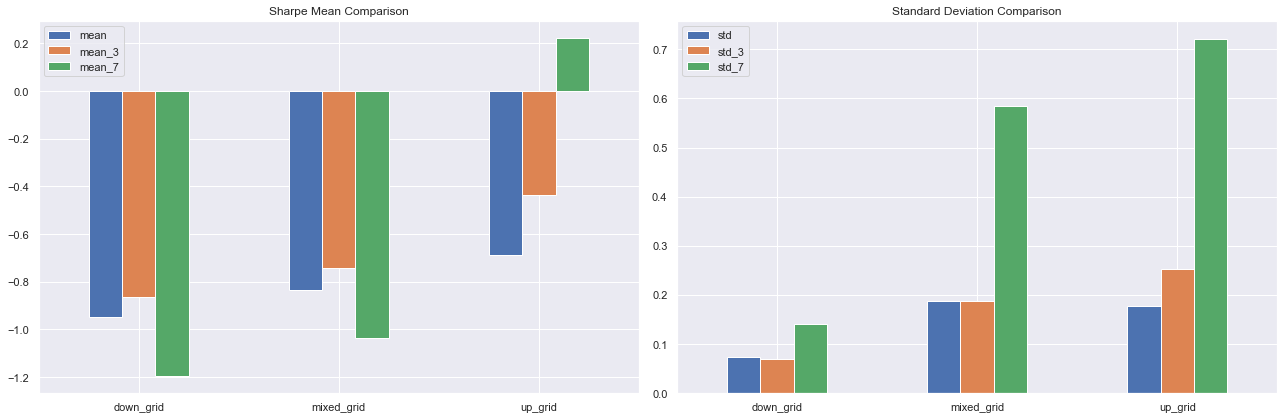

In [563]:
sns.set_theme()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6)) 

results[['mean', 'mean_3', 'mean_7']].plot(kind='bar', ax=axes[0], title='Sharpe Mean Comparison')
results[['std', 'std_3', 'std_7']].plot(kind='bar', ax=axes[1], title='Standard Deviation Comparison')
axes[0].set_xticklabels(results.index, rotation=0)
axes[1].set_xticklabels(results.index, rotation=0)
plt.tight_layout()

plt.show()

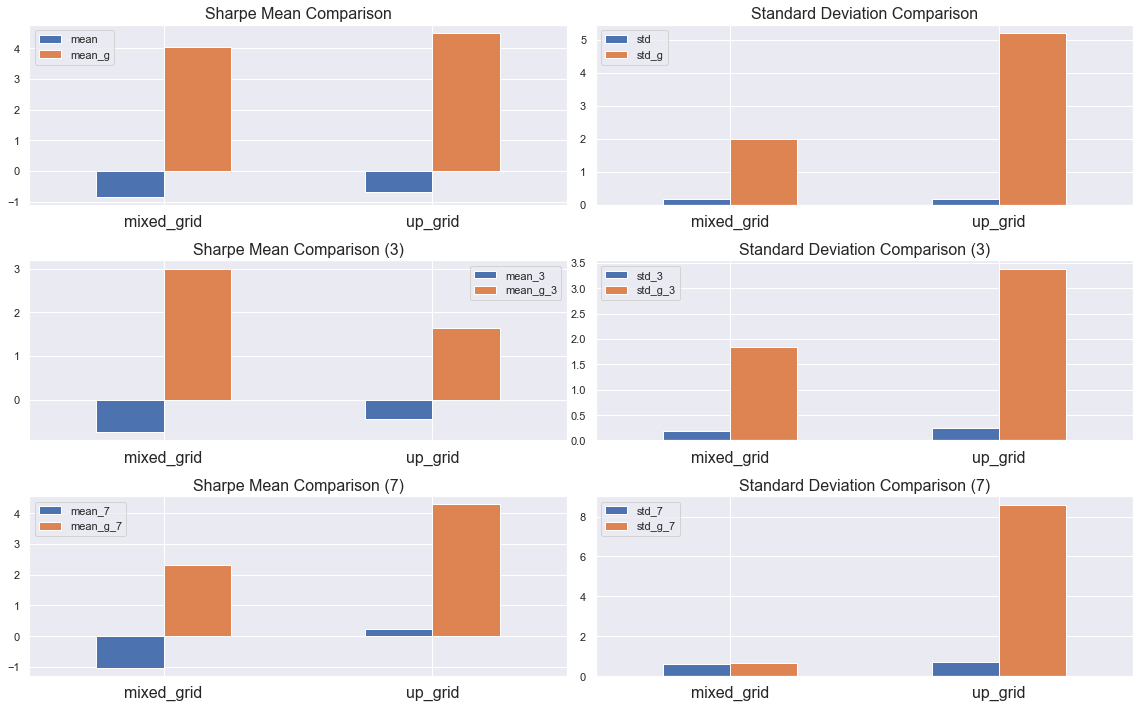

In [578]:
# Plotting
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 10))

# Plot for 'mean' and 'mean_g'
df[['mean', 'mean_g']].plot(kind='bar', ax=axes[0, 0])
axes[0,0].set_xticklabels(df.index, rotation=0,  size=16)
axes[0,0].set_title(label = 'Sharpe Mean Comparison', size=16)
# Plot for 'std' and 'std_g'
df[['std', 'std_g']].plot(kind='bar', ax=axes[0, 1])
axes[0,1].set_xticklabels(df.index, rotation=0,  size=16)
axes[0,1].set_title(label = 'Standard Deviation Comparison', size=16)
# Plot for 'mean_3' and 'mean_g_3'
df[['mean_3', 'mean_g_3']].plot(kind='bar', ax=axes[1, 0], title='Sharpe Mean Comparison (3)')
axes[1,0].set_xticklabels(df.index, rotation=0,  size=16)
axes[1,0].set_title(label = 'Sharpe Mean Comparison (3)', size=16)
# Plot for 'std_3' and 'std_g_3'
df[['std_3', 'std_g_3']].plot(kind='bar', ax=axes[1, 1])
axes[1,1].set_xticklabels(df.index, rotation=0,  size=16)
axes[1,1].set_title(label = 'Standard Deviation Comparison (3)', size=16)
# Plot for 'mean_3' and 'mean_g_3'
df[['mean_7', 'mean_g_7']].plot(kind='bar', ax=axes[2, 0])
axes[2,0].set_xticklabels(df.index, rotation=0,  size=16)
axes[2,0].set_title(label = 'Sharpe Mean Comparison (7)', size=16)
# Plot for 'std_3' and 'std_g_3'
df[['std_7', 'std_g_7']].plot(kind='bar', ax=axes[2, 1])
axes[2,1].set_xticklabels(df.index, rotation=0,  size=16)
axes[2,1].set_title(label = 'Standard Deviation Comparison (7)', size=16)

plt.tight_layout()
plt.show()

In [561]:
df

,mean,std,mean_g,std_g,mean_3,std_3,mean_g_3,std_g_3,mean_7,std_7,mean_g_7,std_g_7
mixed_grid,-0.835,0.187,4.041,1.987,-0.744,0.187,2.998,1.841,-1.037,0.584,2.306,0.643
up_grid,-0.686,0.177,4.500,5.197,-0.438,0.252,1.647,3.376,0.224,0.722,4.291,8.593
